<a href="https://www.kaggle.com/woosunglee0118/mlb-player-digital-engagement-forcasting?scriptVersionId=88520949" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# MLB PLAYER DIGITAL ENGAGEMENT FORCASTING

## 1. INTRODUCTION



MLB teamed up with Google Cloud, hold this Kaggle competition to transform the fan experience through data.

In this competition, we will predict how fans engage with MLB players’ digital content on a daily basis for a future date range.

We will have access to player performance data, social media data, and team factors like market size. 

we are going to find features that are related to fan engagement such as home run, and by using the features, the model predicts the fan engagement values.



In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_absolute_error
from datetime import timedelta
from functools import reduce
from tqdm import tqdm
import lightgbm as lgbm
import mlb
BASE_DIR = Path('../input/mlb-player-digital-engagement-forecasting')
TRAIN_DIR = Path('../input/mlb-pdef-train-dataset')

In [2]:
pd.read_csv(BASE_DIR / 'example_sample_submission.csv')

date    date_playerId  target1  target2  target3  target4
0     20210426  20210427_656669        0        0        0        0
1     20210426  20210427_543475        0        0        0        0
2     20210426  20210427_592866        0        0        0        0
3     20210426  20210427_452678        0        0        0        0
4     20210426  20210427_570257        0        0        0        0
...        ...              ...      ...      ...      ...      ...
5930  20210430  20210501_596049        0        0        0        0
5931  20210430  20210501_642851        0        0        0        0
5932  20210430  20210501_596071        0        0        0        0
5933  20210430  20210501_664901        0        0        0        0
5934  20210430  20210501_605525        0        0        0        0

[5935 rows x 6 columns]

Let's see an example submission that we have to submit for the competition. 

In this competition, we have to find fan engagement scores (target 1,2,3,4) by date and player with given data.

In column 0, the fan engagement result (target 1 to 4) of PlayerId 656669 on Apr 27 are all Zero.

we can guess on the date 2021 April 26 a day before the 27th, there were no games or the player did not play the game based on fan engagement values.




 If the given information is highly related to the 4 target values, we can find the most correlated features. 
 
 The first time, I guessed information such as ‘Homerun’ or ‘no-hit no run’ can be the most important features. 
 
 However, 4 target values are not correlated with these kinds of features. 
 
 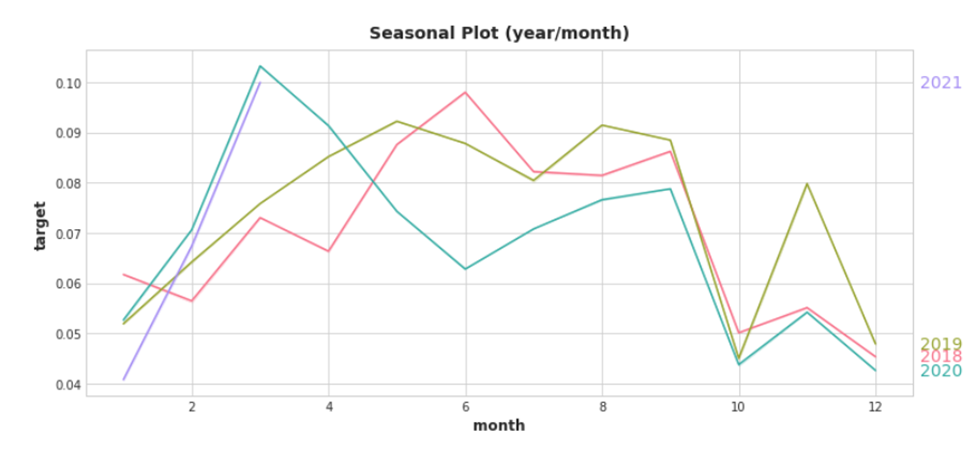
 
 **The Picture of an EDA result of 'AVG target values by Year-Month' from the Kaggle NB => https://www.kaggle.com/ryanholbrook/getting-started-with-mlb-player-digital-engagement**
 
 
 Instead of the previous hypothesis, 4 target values show some trends by time. 
 
 Therefore, this competition is similar to time series data prediction such as temperature prediction or stock price prediction.

## 2. MODEL ##


Before explaining our model, I will explain the time period of train and test data.


We got train data from **2018 to 24 April 2021**. 

Public Leader Board provides **25 April 2021 to the last day of April 2021.**

At the End of the competition, the model has to predict some other period time **later than May 1, 2021.** Which is evaluation test data.

I will call 2018 to 31 March 2021 as **train data**, 1 April 2021 to 24th April 2021 as **valid test data.**

Public Leader Board provides data from 25 April 2021 to the last day of April 2021. With train data, Most of the groups made their valid test data from 1 April 2021 to 24th April 2021.




### a. THE FIRST MODEL ###






In [3]:
First_model_feature_cols = ['label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances', 
'target1_mean',
 'target1_median',
 'target1_std',
 'target1_min',
 'target1_max',
 'target1_prob',
 'target2_mean',
 'target2_median',
 'target2_std',
 'target2_min',
 'target2_max',
 'target2_prob',
 'target3_mean',
 'target3_median',
 'target3_std',
 'target3_min',
 'target3_max',
 'target3_prob',
 'target4_mean',
 'target4_median',
 'target4_std',
 'target4_min',
 'target4_max',
 'target4_prob'
               ]


I put game features on the LightGBM model such as ‘homerun’, ‘playerId’, ‘TeamId’.
And also I include statistical data such as 'target1_median', 'target_2_std' ect... 

These are the valid test scores for our LightGBM model. **Target 1 for about 0.675, Target 2: 1.43 Target 3: 0.55 target 4: 1.12.** The average of the Mean absolute error is **0.947.** All the hyperparameters are tuned to get high valid test scores.

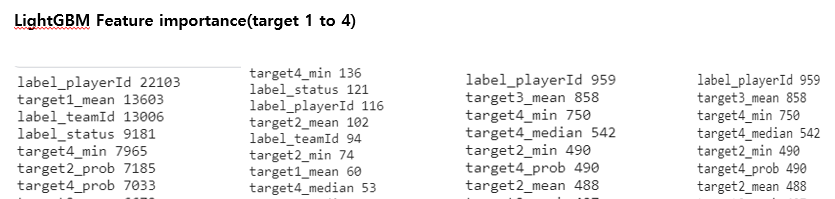


Now we will see the feature importance from target 1 to target 4.

**Player Id** is the most important feature for the target 1 prediction LightGBM model.

**Target4_min** which is one of the statistical values is the most important feature for the target 2 prediction LightGBM model.

**Player Id** is the most important feature for the target 3 prediction LightGBM model.

**Player Id** is the most important feature for the target 4 prediction LightGBM model.

This result shows **statistical information** and **player_id** is a good feature for the model. However, when we think about the result, It is common sense that a popular MLB player is always highlighted by others while a non-popular MLB player is not.



### b. THE ADVENCED MODEL ###

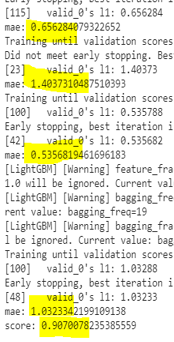
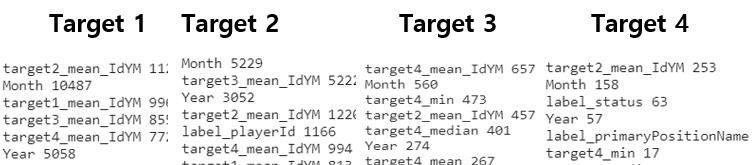

First, I tried to change statistical features. 

If we see the feature importance, most of the statistical features are highly ranked. I got the mean values of each target by applying the 'group by' function with playerId, month, and Year. The previous EDA picture gave me the idea for applying the 'group by' function with month and Year. 

In addition, the previous model’s feature importance gives me the idea for applying the 'group by' function with playerID. Also, I put Day, Month, Year to the features for the new model. I assume that the LighGBM model finds a connection between the statistical features and Day Month Years by expanding its dimension.



For the result, I reduced valid test scores from 0.95(first model valid test score) to 0.90. 

The previous valid test score is from a fully tuned model while the new model’s hyperparameter is never tuned. 
If we see the feature importance lists, we can see new features are highly ranked.

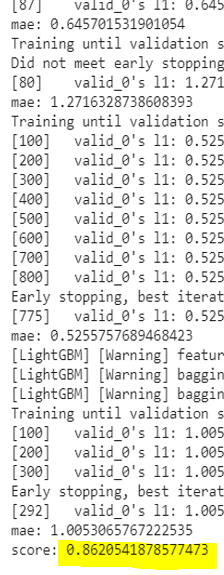

I put more statistical features into the model. 
I put not only the mean target values applying with groupby function, but also max, min std median with groupby fuction.
The valid test score became 0.86 and this score is also without any parameter tuning. 
**Even without hyperparameter tunning, the model shows a similar valid train score with many other groups who are in the top public leaderboard score.**




In this competition discussion board, many participants who got top public test scores have argued that top scores models on the boards are overfitted or used leaked data. If we see the public test data, it starts from 25 April to 30 April 2021. And Train data includes 2021 April data. The models might be fit to find a good score for the April 2021 test data. However, the competition's final private test data is starting from May 2021. Therefore, **I decided to use a totally different approach to train the model.**

### Statistical Features for the New train data
#### 1. Same month but previous year
#### Player A(May. 15. 2021) : Player A target mean value (May 2020 , May 2019)


I decided to add target mean values with the same month but the previous year each row for the train data.

If there is a May 15th, 2021 train data row for player A, I calculated target mean values of May 2020 and May 2019 and put them into features for the model.

When we compare sales revenues by quarters for a company, usually economists compare present quarter revenue with not the previous quarter's revenues but same quarter revenues in a previous year.  My first feature engineering idea came from this.


#### 2. Target mean values with previous month and next month but the previous years'
#### Player A(May. 15. 2021) : Player A harget mean value (April 2020 , Jun 2020)



If there is a May 15th, 2021 train data row for player A, I calculated target mean values of April 2020 and Jun 2020 for player A and put them into features for the model.

 Based on the EDA graph, If I want to get one of May's target values, April and Jun data can be a good feature. However, in the test set, we cannot get future-month of statistical features. Therefore, instead of 2021 April and Jun mean target values, I put 2020 April and Jun mean target values in this example case. But these features are from the previous year one, therefore, I thought it require something that helps to connect the previous year (2020) and this year(2021)


#### 3. A ratio of this year target mean values by previous year target mean values
#### Player A (May. 15. 2021):  Player A target mean value(Jan+Feb+Mar 2021) **/** Player A target mean value(Jan+Feb+Mar 2020)



To connect precious year and this year, I calculated a ratio of this year's target mean values by the previous year's target mean value. 

However, in the train data. when we think about the period of our train data, 2021 target values are ends April 25. Since Jan Feb Mar data are complete data, each year of Jan, Feb, Mar target values are used to get the ratio.
Then this can represent a hypothetical rising MLB star showing higher target values year by year with this ratio features.

#### Result for the advenced model
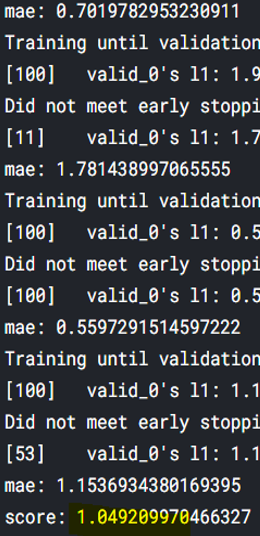
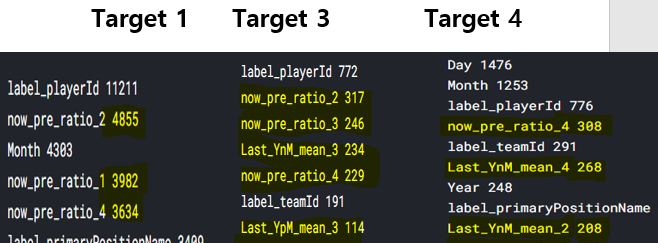



Here is the result for the advanced model.

The valid test score is not good as the previous model (0.85 to 1) however, I think this model is made by my logical sequence to avoid overfitting. According to the feature importance result,**surprisingly this model seems to found some relationships between player, date, and feature that I made.**

In [4]:
players = pd.read_csv(BASE_DIR / 'players.csv')
rosters = pd.read_pickle(TRAIN_DIR / 'rosters_train.pkl')
targets = pd.read_pickle(TRAIN_DIR / 'nextDayPlayerEngagement_train.pkl')
scores = pd.read_pickle(TRAIN_DIR / 'playerBoxScores_train.pkl')
scores = scores.groupby(['playerId', 'date']).sum().reset_index()

In [5]:
targets_cols = ['playerId', 'target1', 'target2', 'target3', 'target4', 'date']
players_cols = ['playerId', 'primaryPositionName']
rosters_cols = ['playerId', 'teamId', 'status', 'date']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances', 'date']

feature_cols = ['label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances', 

               ]

In [6]:
train = pd.read_csv("../input/wsl-dc/mycsvfile.csv")

In [7]:
player_target_stats = pd.read_csv("../input/player-target-stats/player_target_stats.csv")


In [8]:
# label encoding
player2num = {c: i for i, c in enumerate(train['playerId'].unique())}
position2num = {c: i for i, c in enumerate(train['primaryPositionName'].unique())}
teamid2num = {c: i for i, c in enumerate(train['teamId'].unique())}
status2num = {c: i for i, c in enumerate(train['status'].unique())}
train['label_playerId'] = train['playerId'].map(player2num)
train['label_primaryPositionName'] = train['primaryPositionName'].map(position2num)
train['label_teamId'] = train['teamId'].map(teamid2num)
train['label_status'] = train['status'].map(status2num)

In [9]:
#original model.

In [10]:
#mae: 1.1210108475080813
#score: 0.9470136325539955

In [11]:
# #IDYM
# train['Month']=train['date'].apply(lambda x : int(str(x)[4:6]))
# train['Year']=train['date'].apply(lambda x : int(str(x)[2:4]))
# train['Day']=train['date'].apply(lambda x : int(str(x)[6:8]))
# #converted model

mean_IdYM=train[['target1','target2','target3','target4',"playerId","Year","Month"]].groupby(["playerId","Year","Month"]).mean()

# #mean_IdYM.iloc(112526,18,1)
# #mean_IdYM=train[['target1','target2','target3','target4',"playerId","Year","Month"]].groupby(["playerId","Year","Month"]).mean()#.get_group((628317,19,1))

In [12]:
            tr_pId = train['playerId']==547989
            tr_M = train['Year']==20
            tr_Y = train['Month']==7
            c = tr_pId & tr_M & tr_Y
            

In [13]:
# train.loc[train[c].index,'Last_YpM_mean_1']=mean_IdYM.loc[(547989,20,7)].target1
#a.Last_YpM_mean_1=mean_IdYM.loc[(547989,19,7)].target1

In [14]:
#mean_IdYM.loc[(547989,20,7)].target1

In [15]:
#train[c]

In [16]:
# train['Last_YpM_mean_1']=0
# train['Last_YpM_mean_2']=0
# train['Last_YpM_mean_3']=0
# train['Last_YpM_mean_4']=0        
# train['Last_YnM_mean_1']=0
# train['Last_YnM_mean_2']=0
# train['Last_YnM_mean_3']=0
# train['Last_YnM_mean_4']=0

# for num,Id in enumerate(train['playerId'].unique()):
#     if num%20==0:
#         print(num)
#     for year in [18,19,20,21]:
#         for month in [1,2,3,4,5,6,7,8,9,10,11,12]:
#             Yp = year -1
#             Yn = year -1
#             Mp = month -1
#             Mn = month +1
            
#             if month==1:
#                 Yp=year-2
#                 Mp=12
#             elif month==12:
#                 Yn=year
#                 Mn=1
            
#             tr_pId = train['playerId']==Id
#             tr_M = train['Month']==month
#             tr_Y = train['Year']==year
#             c = tr_pId & tr_M & tr_Y
#             try:
#                 train.loc[train[c].index,'Last_YpM_mean_1']=mean_IdYM.loc[(Id,Yp,Mp)].target1
#             except:
#                 train.loc[train[c].index,'Last_YpM_mean_1']=np.nan
#             try:
#                 train.loc[train[c].index,'Last_YpM_mean_2']=mean_IdYM.loc[(Id,Yp,Mp)].target2
#             except:
#                 train.loc[train[c].index,'Last_YpM_mean_2']=np.nan
#             try:
#                 train.loc[train[c].index,'Last_YpM_mean_3']=mean_IdYM.loc[(Id,Yp,Mp)].target3
#             except:
#                 train.loc[train[c].index,'Last_YpM_mean_3']=np.nan
#             try:
#                 train.loc[train[c].index,'Last_YpM_mean_4']=mean_IdYM.loc[(Id,Yp,Mp)].target4
#             except:
#                 train.loc[train[c].index,'Last_YpM_mean_4']=np.nan            
            
            
#             try:
#                 train.loc[train[c].index,'Last_YnM_mean_1']=mean_IdYM.loc[(Id,Yn,Mn)].target1
#             except:
#                 train.loc[train[c].index,'Last_YnM_mean_1']=np.nan
#             try:
#                 train.loc[train[c].index,'Last_YnM_mean_2']=mean_IdYM.loc[(Id,Yn,Mn)].target2
#             except:
#                 train.loc[train[c].index,'Last_YnM_mean_2']=np.nan
#             try:
#                 train.loc[train[c].index,'Last_YnM_mean_3']=mean_IdYM.loc[(Id,Yn,Mn)].target3
#             except:
#                 train.loc[train[c].index,'Last_YnM_mean_3']=np.nan
#             try:
#                 train.loc[train[c].index,'Last_YnM_mean_4']=mean_IdYM.loc[(Id,Yn,Mn)].target4
#             except:
#                 train.loc[train[c].index,'Last_YnM_mean_4']=np.nan
                
                
 
                
                    
            
    
        
    

In [17]:
# 

In [18]:
######################################
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type == 'datetime64[ns]':
            continue
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
train=reduce_mem_usage(train)


Memory usage of dataframe is 2313.59 MB
Memory usage after optimization is: 568.84 MB
Decreased by 75.4%


In [19]:
#mean_IdYM=train[['target1','target2','target3','target4',"playerId","Year","Month"]].groupby(["playerId","Year","Month"]).mean()#.get_group((628317,19,1))

In [20]:
#train['playerId'].unique()
#train['Year'].unique()
#train['Month'].unique()

In [21]:
#train[['target1','target2','target3','target4',"playerId","Year","Month"]].groupby(["playerId","Year","Month"]).get_group((628317,19,1))

In [22]:
#train[train['Year']==18].groupby(["playerId","Month"]).mean()
pre_tr=train[['target1','target2','target3','target4',"playerId","Year","Month"]]
pre_tr

target1    target2    target3   target4  playerId  Year  Month
0         0.011169   4.476562   0.005169  5.734375    628317    18      1
1         0.006355   2.521484   0.001648  2.767578    628317    18      1
2         0.003557   2.380859   0.003624  3.439453    628317    18      1
3         0.003363   3.332031   0.012291  4.847656    628317    18      1
4         0.023972   1.440430   0.001500  2.371094    628317    18      1
...            ...        ...        ...       ...       ...   ...    ...
2506171  16.921875  13.335938   5.035156  4.136719    656775    21      4
2506172   1.780273   8.039062   0.287109  2.361328    656775    21      4
2506173  12.437500  17.296875  11.023438  4.128906    656775    21      4
2506174  10.765625   9.601562   7.968750  2.996094    656775    21      4
2506175   7.449219   8.171875   0.855469  2.673828    656775    21      4

[2506176 rows x 7 columns]

In [23]:
train

playerId    target1    target2    target3   target4      date  \
0          628317   0.011169   4.476562   0.005169  5.734375  20180101   
1          628317   0.006355   2.521484   0.001648  2.767578  20180102   
2          628317   0.003557   2.380859   0.003624  3.439453  20180103   
3          628317   0.003363   3.332031   0.012291  4.847656  20180104   
4          628317   0.023972   1.440430   0.001500  2.371094  20180105   
...           ...        ...        ...        ...       ...       ...   
2506171    656775  16.921875  13.335938   5.035156  4.136719  20210426   
2506172    656775   1.780273   8.039062   0.287109  2.361328  20210427   
2506173    656775  12.437500  17.296875  11.023438  4.128906  20210428   
2506174    656775  10.765625   9.601562   7.968750  2.996094  20210429   
2506175    656775   7.449219   8.171875   0.855469  2.673828  20210430   

        primaryPositionName  teamId  status  battingOrder  ...  Year  Day  \
0                   Pitcher   119.0  Active           NaN  ...    18    1   
1                   Pitcher   119.0  Active           NaN  ...    18    2   
2                   Pitcher   119.0  Active           NaN  ...    18    3   
3                   Pitcher   119.0  Active           NaN  ...    18    4   
4                   Pitcher   119.0  Active           NaN  ...    18    5   
...                     ...     ...     ...           ...  ...   ...  ...   
2506171          Outfielder   110.0  Active         100.0  ...    21   26   
2506172          Outfielder   110.0  Active         100.0  ...    21   27   
2506173          Outfielder   110.0  Active         100.0  ...    21   28   
2506174          Outfielder   110.0  Active         100.0  ...    21   29   
2506175          Outfielder   110.0  Active         100.0  ...    21   30   

         Last_YpM_mean_1  Last_YpM_mean_2  Last_YpM_mean_3  Last_YpM_mean_4  \
0                    NaN              NaN              NaN              NaN   
1                    NaN              NaN              NaN              NaN   
2                    NaN              NaN              NaN              NaN   
3                    NaN              NaN              NaN              NaN   
4                    NaN              NaN              NaN              NaN   
...                  ...              ...              ...              ...   
2506171         0.479004         3.445312         0.365479         0.776855   
2506172         0.479004         3.445312         0.365479         0.776855   
2506173         0.479004         3.445312         0.365479         0.776855   
2506174         0.479004         3.445312         0.365479         0.776855   
2506175         0.479004         3.445312         0.365479         0.776855   

         Last_YnM_mean_1  Last_YnM_mean_2  Last_YnM_mean_3  Last_YnM_mean_4  
0                    NaN              NaN              NaN              NaN  
1                    NaN              NaN              NaN              NaN  
2                    NaN              NaN              NaN              NaN  
3                    NaN              NaN              NaN              NaN  
4                    NaN              NaN              NaN              NaN  
...                  ...              ...              ...              ...  
2506171         0.010712         1.774414         0.034363         0.126343  
2506172         0.010712         1.774414         0.034363         0.126343  
2506173         0.010712         1.774414         0.034363         0.126343  
2506174         0.010712         1.774414         0.034363         0.126343  
2506175         0.010712         1.774414         0.034363         0.126343  

[2506176 rows x 121 columns]

In [24]:
pre_tr

target1    target2    target3   target4  playerId  Year  Month
0         0.011169   4.476562   0.005169  5.734375    628317    18      1
1         0.006355   2.521484   0.001648  2.767578    628317    18      1
2         0.003557   2.380859   0.003624  3.439453    628317    18      1
3         0.003363   3.332031   0.012291  4.847656    628317    18      1
4         0.023972   1.440430   0.001500  2.371094    628317    18      1
...            ...        ...        ...       ...       ...   ...    ...
2506171  16.921875  13.335938   5.035156  4.136719    656775    21      4
2506172   1.780273   8.039062   0.287109  2.361328    656775    21      4
2506173  12.437500  17.296875  11.023438  4.128906    656775    21      4
2506174  10.765625   9.601562   7.968750  2.996094    656775    21      4
2506175   7.449219   8.171875   0.855469  2.673828    656775    21      4

[2506176 rows x 7 columns]

In [25]:
m1 = pre_tr['Month']==1
m2 = pre_tr['Month']==2
m3 = pre_tr['Month']==3
Y18 = pre_tr['Year']==18
Y19 = pre_tr['Year']==19
Y20 = pre_tr['Year']==20
Y21 = pre_tr['Year']==21

m1_3=m1|m2|m3
m1_3Y18=m1_3&Y18
m1_3Y19=m1_3&Y19
m1_3Y20=m1_3&Y20
m1_3Y21=m1_3&Y21

tr_18_123 = pre_tr[m1_3Y18].groupby(["playerId"]).mean()
tr_19_123 = pre_tr[m1_3Y19].groupby(["playerId"]).mean()
tr_20_123 = pre_tr[m1_3Y20].groupby(["playerId"]).mean()
tr_21_123 = pre_tr[m1_3Y21].groupby(["playerId"]).mean()

In [26]:
tr_18_123=tr_18_123.drop('Month',axis=1)
tr_19_123=tr_19_123.drop('Month',axis=1)
tr_20_123=tr_20_123.drop('Month',axis=1)
tr_21_123=tr_21_123.drop('Month',axis=1)

In [27]:
tr_21_123

target1   target2   target3    target4  Year
playerId                                               
112526    0.062622  0.843262  0.382812  11.132812    21
134181    0.605469  0.694336  0.581055   5.617188    21
279571    0.000154  0.033478  0.000118   0.171509    21
282332    1.267578  0.854004  0.333740  14.078125    21
400085    0.826660  2.873047  2.855469  30.718750    21
...            ...       ...       ...        ...   ...
681911    0.038971  4.265625  3.230469   0.674805    21
683232    0.000650  0.943848  0.091125   0.108582    21
683734    2.595703  7.250000  7.785156   2.996094    21
685493    0.273438  3.316406  0.860840   1.452148    21
685503    0.174194  5.152344  0.398926   1.192383    21

[2061 rows x 5 columns]

In [28]:
train['now_1_mean_123']=0
train['now_2_mean_123']=0
train['now_3_mean_123']=0
train['now_4_mean_123']=0

tr_list=[tr_18_123 ,tr_19_123 ,tr_20_123 ,tr_21_123]
for ele in tr_list:
    train=train.merge(ele,on=["playerId","Year"],how='left',suffixes=('', '_y'))
    #print(np.nan_to_num(train['target1_y'], copy=False))
    train['now_1_mean_123']=np.nan_to_num(train['target1_y'], copy=False)+train['now_1_mean_123']
    train['now_2_mean_123']=np.nan_to_num(train['target2_y'], copy=False)+train['now_2_mean_123']
    train['now_3_mean_123']=np.nan_to_num(train['target3_y'], copy=False)+train['now_3_mean_123']
    train['now_4_mean_123']=np.nan_to_num(train['target4_y'], copy=False)+train['now_4_mean_123']
    train=train.drop(['target1_y','target2_y','target3_y','target4_y'],axis=1)
    
train['now_1_mean_123']=train['now_1_mean_123'].map(lambda x : np.nan if x==0 else x)
train['now_2_mean_123']=train['now_2_mean_123'].map(lambda x : np.nan if x==0 else x)
train['now_3_mean_123']=train['now_3_mean_123'].map(lambda x : np.nan if x==0 else x)
train['now_4_mean_123']=train['now_4_mean_123'].map(lambda x : np.nan if x==0 else x)

In [29]:
train

playerId    target1    target2    target3   target4      date  \
0          628317   0.011169   4.476562   0.005169  5.734375  20180101   
1          628317   0.006355   2.521484   0.001648  2.767578  20180102   
2          628317   0.003557   2.380859   0.003624  3.439453  20180103   
3          628317   0.003363   3.332031   0.012291  4.847656  20180104   
4          628317   0.023972   1.440430   0.001500  2.371094  20180105   
...           ...        ...        ...        ...       ...       ...   
2506171    656775  16.921875  13.335938   5.035156  4.136719  20210426   
2506172    656775   1.780273   8.039062   0.287109  2.361328  20210427   
2506173    656775  12.437500  17.296875  11.023438  4.128906  20210428   
2506174    656775  10.765625   9.601562   7.968750  2.996094  20210429   
2506175    656775   7.449219   8.171875   0.855469  2.673828  20210430   

        primaryPositionName  teamId  status  battingOrder  ...  \
0                   Pitcher   119.0  Active           NaN  ...   
1                   Pitcher   119.0  Active           NaN  ...   
2                   Pitcher   119.0  Active           NaN  ...   
3                   Pitcher   119.0  Active           NaN  ...   
4                   Pitcher   119.0  Active           NaN  ...   
...                     ...     ...     ...           ...  ...   
2506171          Outfielder   110.0  Active         100.0  ...   
2506172          Outfielder   110.0  Active         100.0  ...   
2506173          Outfielder   110.0  Active         100.0  ...   
2506174          Outfielder   110.0  Active         100.0  ...   
2506175          Outfielder   110.0  Active         100.0  ...   

         Last_YpM_mean_3  Last_YpM_mean_4  Last_YnM_mean_1  Last_YnM_mean_2  \
0                    NaN              NaN              NaN              NaN   
1                    NaN              NaN              NaN              NaN   
2                    NaN              NaN              NaN              NaN   
3                    NaN              NaN              NaN              NaN   
4                    NaN              NaN              NaN              NaN   
...                  ...              ...              ...              ...   
2506171         0.365479         0.776855         0.010712         1.774414   
2506172         0.365479         0.776855         0.010712         1.774414   
2506173         0.365479         0.776855         0.010712         1.774414   
2506174         0.365479         0.776855         0.010712         1.774414   
2506175         0.365479         0.776855         0.010712         1.774414   

         Last_YnM_mean_3  Last_YnM_mean_4  now_1_mean_123  now_2_mean_123  \
0                    NaN              NaN        0.275146        6.289062   
1                    NaN              NaN        0.275146        6.289062   
2                    NaN              NaN        0.275146        6.289062   
3                    NaN              NaN        0.275146        6.289062   
4                    NaN              NaN        0.275146        6.289062   
...                  ...              ...             ...             ...   
2506171         0.034363         0.126343        1.021484        2.992188   
2506172         0.034363         0.126343        1.021484        2.992188   
2506173         0.034363         0.126343        1.021484        2.992188   
2506174         0.034363         0.126343        1.021484        2.992188   
2506175         0.034363         0.126343        1.021484        2.992188   

         now_3_mean_123  now_4_mean_123  
0              4.722656        1.823242  
1              4.722656        1.823242  
2              4.722656        1.823242  
3              4.722656        1.823242  
4              4.722656        1.823242  
...                 ...             ...  
2506171        0.263672        0.452881  
2506172        0.263672        0.452881  
2506173        0.263672        0.452881  
2506174        0.263672        0.

In [30]:
train['pre_1_mean_123']=0
train['pre_2_mean_123']=0
train['pre_3_mean_123']=0
train['pre_4_mean_123']=0

tr_list=[tr_18_123 ,tr_19_123 ,tr_20_123]
for ele in tr_list:
    ele["Year"]=ele["Year"]+1
    train=train.merge(ele,on=["playerId","Year"],how='left',suffixes=('', '_y'))
    ele["Year"]=ele["Year"]-1
    #print(np.nan_to_num(train['target1_y'], copy=False))
    train['pre_1_mean_123']=np.nan_to_num(train['target1_y'], copy=False)+train['pre_1_mean_123']
    train['pre_2_mean_123']=np.nan_to_num(train['target2_y'], copy=False)+train['pre_2_mean_123']
    train['pre_3_mean_123']=np.nan_to_num(train['target3_y'], copy=False)+train['pre_3_mean_123']
    train['pre_4_mean_123']=np.nan_to_num(train['target4_y'], copy=False)+train['pre_4_mean_123']
    train=train.drop(['target1_y','target2_y','target3_y','target4_y'],axis=1)
    
train['pre_1_mean_123']=train['pre_1_mean_123'].map(lambda x : np.nan if x==0 else x)
train['pre_2_mean_123']=train['pre_2_mean_123'].map(lambda x : np.nan if x==0 else x)
train['pre_3_mean_123']=train['pre_3_mean_123'].map(lambda x : np.nan if x==0 else x)
train['pre_4_mean_123']=train['pre_4_mean_123'].map(lambda x : np.nan if x==0 else x)


In [31]:

train['now_pre_ratio_1']=train["now_1_mean_123"]/train["pre_1_mean_123"]
train['now_pre_ratio_2']=train["now_2_mean_123"]/train["pre_2_mean_123"]
train['now_pre_ratio_3']=train["now_3_mean_123"]/train["pre_3_mean_123"]
train['now_pre_ratio_4']=train["now_4_mean_123"]/train["pre_4_mean_123"]

In [32]:
#####################################################################################

In [33]:
train['now_pre_ratio_1']

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
             ...   
2506171    4.320083
2506172    4.320083
2506173    4.320083
2506174    4.320083
2506175    4.320083
Name: now_pre_ratio_1, Length: 2506176, dtype: float64

In [34]:
###############################
tr_18=pre_tr[pre_tr['Year']==18].groupby(["playerId","Month"]).mean()
tr_19=pre_tr[pre_tr['Year']==19].groupby(["playerId","Month"]).mean()
tr_20=pre_tr[pre_tr['Year']==20].groupby(["playerId","Month"]).mean()
tr_21=pre_tr[pre_tr['Year']==21].groupby(["playerId","Month"]).mean()


In [35]:
#############################
train['now_1_mean']=0
train['now_2_mean']=0
train['now_3_mean']=0
train['now_4_mean']=0
tr_list=[tr_18,tr_19,tr_20,tr_21]
for ele in tr_list:
    train=train.merge(ele,on=["playerId","Month","Year"],how='left',suffixes=('', '_y'))
    #print(np.nan_to_num(train['target1_y'], copy=False))
    train['now_1_mean']=np.nan_to_num(train['target1_y'], copy=False)+train['now_1_mean']
    train['now_2_mean']=np.nan_to_num(train['target2_y'], copy=False)+train['now_2_mean']
    train['now_3_mean']=np.nan_to_num(train['target3_y'], copy=False)+train['now_3_mean']
    train['now_4_mean']=np.nan_to_num(train['target4_y'], copy=False)+train['now_4_mean']
    train=train.drop(['target1_y','target2_y','target3_y','target4_y'],axis=1)
    
train['now_1_mean']=train['now_1_mean'].map(lambda x : np.nan if x==0 else x)
train['now_2_mean']=train['now_2_mean'].map(lambda x : np.nan if x==0 else x)
train['now_3_mean']=train['now_3_mean'].map(lambda x : np.nan if x==0 else x)
train['now_4_mean']=train['now_4_mean'].map(lambda x : np.nan if x==0 else x)

In [36]:
#
train['pre_1_mean']=0
train['pre_2_mean']=0
train['pre_3_mean']=0
train['pre_4_mean']=0
tr_list=[tr_18,tr_19,tr_20]
for ele in tr_list:
    ele["Year"]=ele["Year"]+1
    train=train.merge(ele,on=["playerId","Month","Year"],how='left',suffixes=('', '_y'))
    ele["Year"]=ele["Year"]-1
    #print(np.nan_to_num(train['target1_y'], copy=False))
    train['pre_1_mean']=np.nan_to_num(train['target1_y'], copy=False)+train['pre_1_mean']
    train['pre_2_mean']=np.nan_to_num(train['target2_y'], copy=False)+train['pre_2_mean']
    train['pre_3_mean']=np.nan_to_num(train['target3_y'], copy=False)+train['pre_3_mean']
    train['pre_4_mean']=np.nan_to_num(train['target4_y'], copy=False)+train['pre_4_mean']
    train=train.drop(['target1_y','target2_y','target3_y','target4_y'],axis=1)
    
train['pre_1_mean']=train['pre_1_mean'].map(lambda x : np.nan if x==0 else x)
train['pre_2_mean']=train['pre_2_mean'].map(lambda x : np.nan if x==0 else x)
train['pre_3_mean']=train['pre_3_mean'].map(lambda x : np.nan if x==0 else x)
train['pre_4_mean']=train['pre_4_mean'].map(lambda x : np.nan if x==0 else x)


In [37]:
##############################
train['ppre_1_mean']=0
train['ppre_2_mean']=0
train['ppre_3_mean']=0
train['ppre_4_mean']=0
for ele in [tr_18,tr_19]:
    ele["Year"]=ele["Year"]+2
    train=train.merge(ele,on=["playerId","Month","Year"],how='left',suffixes=('', '_y'))
    ele["Year"]=ele["Year"]-2
    #print(np.nan_to_num(train['target1_y'], copy=False))
    train['ppre_1_mean']=np.nan_to_num(train['target1_y'], copy=False)+train['ppre_1_mean']
    train['ppre_2_mean']=np.nan_to_num(train['target2_y'], copy=False)+train['ppre_2_mean']
    train['ppre_3_mean']=np.nan_to_num(train['target3_y'], copy=False)+train['ppre_3_mean']
    train['ppre_4_mean']=np.nan_to_num(train['target4_y'], copy=False)+train['ppre_4_mean']
    train=train.drop(['target1_y','target2_y','target3_y','target4_y'],axis=1)
    
train['ppre_1_mean']=train['ppre_1_mean'].map(lambda x : np.nan if x==0 else x)
train['ppre_2_mean']=train['ppre_2_mean'].map(lambda x : np.nan if x==0 else x)
train['ppre_3_mean']=train['ppre_3_mean'].map(lambda x : np.nan if x==0 else x)
train['ppre_4_mean']=train['ppre_4_mean'].map(lambda x : np.nan if x==0 else x)

In [38]:
###########################
train['pppre_1_mean']=0
train['pppre_2_mean']=0
train['pppre_3_mean']=0
train['pppre_4_mean']=0
for ele in [tr_18]:
    ele["Year"]=ele["Year"]+3
    train=train.merge(ele,on=["playerId","Month","Year"],how='left',suffixes=('', '_y'))
    ele["Year"]=ele["Year"]-3
    train['pppre_1_mean']=np.nan_to_num(train['target1_y'], copy=False)+train['pppre_1_mean']
    train['pppre_2_mean']=np.nan_to_num(train['target2_y'], copy=False)+train['pppre_2_mean']
    train['pppre_3_mean']=np.nan_to_num(train['target3_y'], copy=False)+train['pppre_3_mean']
    train['pppre_4_mean']=np.nan_to_num(train['target4_y'], copy=False)+train['pppre_4_mean']
    train=train.drop(['target1_y','target2_y','target3_y','target4_y'],axis=1)
    
train['pppre_1_mean']=train['pppre_1_mean'].map(lambda x : np.nan if x==0 else x)
train['pppre_2_mean']=train['pppre_2_mean'].map(lambda x : np.nan if x==0 else x)
train['pppre_3_mean']=train['pppre_3_mean'].map(lambda x : np.nan if x==0 else x)
train['pppre_4_mean']=train['pppre_4_mean'].map(lambda x : np.nan if x==0 else x)

In [39]:
##DEFFFFF
##########################################################################

tr_18=pre_tr[pre_tr['Year']==18].groupby(["playerId","Month"]).median()
tr_19=pre_tr[pre_tr['Year']==19].groupby(["playerId","Month"]).median()
tr_20=pre_tr[pre_tr['Year']==20].groupby(["playerId","Month"]).median()
tr_21=pre_tr[pre_tr['Year']==21].groupby(["playerId","Month"]).median()
p_median=[
    'now_1_median',
    'now_2_median',
    'now_3_median',
    'now_4_median',
    'pre_1_median',
'pre_2_median',
'pre_3_median',
'pre_4_median',
'ppre_1_median',
'ppre_2_median',
'ppre_3_median',
'ppre_4_median',
'pppre_1_median',
'pppre_2_median',
'pppre_3_median',
'pppre_4_median']

train['pre_1_median']=0
train['pre_2_median']=0
train['pre_3_median']=0
train['pre_4_median']=0
train['ppre_1_median']=0
train['ppre_2_median']=0
train['ppre_3_median']=0
train['ppre_4_median']=0
train['pppre_1_median']=0
train['pppre_2_median']=0
train['pppre_3_median']=0
train['pppre_4_median']=0

train['now_1_median']=0
train['now_2_median']=0
train['now_3_median']=0
train['now_4_median']=0
tr_list=[tr_18,tr_19,tr_20,tr_21]
for ele in tr_list:
    train=train.merge(ele,on=["playerId","Month","Year"],how='left',suffixes=('', '_y'))
    #print(np.nan_to_num(train['target1_y'], copy=False))
    train['now_1_median']=np.nan_to_num(train['target1_y'], copy=False)+train['now_1_median']
    train['now_2_median']=np.nan_to_num(train['target2_y'], copy=False)+train['now_2_median']
    train['now_3_median']=np.nan_to_num(train['target3_y'], copy=False)+train['now_3_median']
    train['now_4_median']=np.nan_to_num(train['target4_y'], copy=False)+train['now_4_median']
    train=train.drop(['target1_y','target2_y','target3_y','target4_y'],axis=1)
    
train['now_1_median']=train['now_1_median'].map(lambda x : np.nan if x==0 else x)
train['now_2_median']=train['now_2_median'].map(lambda x : np.nan if x==0 else x)
train['now_3_median']=train['now_3_median'].map(lambda x : np.nan if x==0 else x)
train['now_4_median']=train['now_4_median'].map(lambda x : np.nan if x==0 else x)


tr_list=[tr_18,tr_19,tr_20]
for ele in tr_list:
    ele["Year"]=ele["Year"]+1
    train=train.merge(ele,on=["playerId","Month","Year"],how='left',suffixes=('', '_y'))
    ele["Year"]=ele["Year"]-1
    #print(np.nan_to_num(train['target1_y'], copy=False))
    train['pre_1_median']=np.nan_to_num(train['target1_y'], copy=False)+train['pre_1_median']
    train['pre_2_median']=np.nan_to_num(train['target2_y'], copy=False)+train['pre_2_median']
    train['pre_3_median']=np.nan_to_num(train['target3_y'], copy=False)+train['pre_3_median']
    train['pre_4_median']=np.nan_to_num(train['target4_y'], copy=False)+train['pre_4_median']
    train=train.drop(['target1_y','target2_y','target3_y','target4_y'],axis=1)
    
for ele in [tr_18,tr_19]:
    ele["Year"]=ele["Year"]+2
    train=train.merge(ele,on=["playerId","Month","Year"],how='left',suffixes=('', '_y'))
    ele["Year"]=ele["Year"]-2
    #print(np.nan_to_num(train['target1_y'], copy=False))
    train['ppre_1_median']=np.nan_to_num(train['target1_y'], copy=False)+train['ppre_1_median']
    train['ppre_2_median']=np.nan_to_num(train['target2_y'], copy=False)+train['ppre_2_median']
    train['ppre_3_median']=np.nan_to_num(train['target3_y'], copy=False)+train['ppre_3_median']
    train['ppre_4_median']=np.nan_to_num(train['target4_y'], copy=False)+train['ppre_4_median']
    train=train.drop(['target1_y','target2_y','target3_y','target4_y'],axis=1)

for ele in [tr_18]:
    ele["Year"]=ele["Year"]+3
    train=train.merge(ele,on=["playerId","Month","Year"],how='left',suffixes=('', '_y'))
    ele["Year"]=ele["Year"]-3
    train['pppre_1_median']=np.nan_to_num(train['target1_y'], copy=False)+train['pppre_1_median']
    train['pppre_2_median']=np.nan_to_num(train['target2_y'], copy=False)+train['pppre_2_median']
    train['pppre_3_median']=np.nan_to_num(train['target3_y'], copy=False)+train['pppre_3_median']
    train['pppre_4_median']=np.nan_to_num(train['target4_y'], copy=False)+train['pppre_4_median']
    train=train.drop(['target1_y','target2_y','target3_y','target4_y'],axis=1)
    
train['pppre_1_median']=train['pppre_1_median'].map(lambda x : np.nan if x==0 else x)
train['pppre_2_median']=train['pppre_2_median'].map(lambda x : np.nan if x==0 else x)
train['pppre_3_median']=train['pppre_3_median'].map(lambda x : np.nan if x==0 else x)
train['pppre_4_median']=train['pppre_4_median'].map(lambda x : np.nan if x==0 else x)
train['ppre_1_median']=train['ppre_1_median'].map(lambda x : np.nan if x==0 else x)
train['ppre_2_median']=train['ppre_2_median'].map(lambda x : np.nan if x==0 else x)
train['ppre_3_median']=train['ppre_3_median'].map(lambda x : np.nan if x==0 else x)
train['ppre_4_median']=train['ppre_4_median'].map(lambda x : np.nan if x==0 else x)
    
train['pre_1_median']=train['pre_1_median'].map(lambda x : np.nan if x==0 else x)
train['pre_2_median']=train['pre_2_median'].map(lambda x : np.nan if x==0 else x)
train['pre_3_median']=train['pre_3_median'].map(lambda x : np.nan if x==0 else x)
train['pre_4_median']=train['pre_4_median'].map(lambda x : np.nan if x==0 else x)


In [40]:
# a=train['playerId']==628317 
# b = train['Day']==19
# c=a&b
# train[c]

In [41]:


#pd.merge(a.pre_1_mean,a.target1_y,how='inner')



In [42]:
#################################################
L_YM=['Last_YpM_mean_1',
'Last_YpM_mean_2',
'Last_YpM_mean_3',
'Last_YpM_mean_4',     
'Last_YnM_mean_1',
'Last_YnM_mean_2',
'Last_YnM_mean_3',
'Last_YnM_mean_4']

Ratio=['now_pre_ratio_1',
'now_pre_ratio_2',
'now_pre_ratio_3',
'now_pre_ratio_4']

p_mean=[
    'now_1_mean',
    'now_2_mean',
    'now_3_mean',
    'now_4_mean',    
'pre_1_mean',
'pre_2_mean',
'pre_3_mean',
'pre_4_mean',
'ppre_1_mean',
'ppre_2_mean',
'ppre_3_mean',
'ppre_4_mean',
'pppre_1_mean',
'pppre_2_mean',
'pppre_3_mean',
'pppre_4_mean']
feature_cols.append('Month')
feature_cols.append('Year')
feature_cols.append('Day')
feature_cols=feature_cols+p_mean+p_median#+p_std+p_min+p_max+p_prod
feature_cols=feature_cols+L_YM+Ratio

In [43]:
##################################
feat_cat=['label_playerId',
 'label_primaryPositionName',
 'label_teamId',
 'label_status',
 'battingOrder',
          'Month',
          'Year',
          'Day'
         ]

In [44]:
#########################################
train_A = train[feature_cols]
train_X = train_A.drop([  
    'now_1_mean',
    'now_2_mean',
    'now_3_mean',
    'now_4_mean', 
    'now_1_median',
    'now_2_median',
    'now_3_median',
    'now_4_median'],axis=1)
train_y = train[['target1', 'target2', 'target3', 'target4']]
_index = (train['date'] < 20210401)
del train
# train_X=reduce_mem_usage(train_X)
# train_y=reduce_mem_usage(train_y)
x_train = train_X.loc[_index].reset_index(drop=True)
y_train = train_y.loc[_index].reset_index(drop=True)
x_valid = train_X.loc[~_index].reset_index(drop=True)
y_valid = train_y.loc[~_index].reset_index(drop=True)

In [45]:
#####################################
feature_cols.remove('now_1_mean')
feature_cols.remove('now_2_mean')
feature_cols.remove('now_3_mean')
feature_cols.remove('now_4_mean')
feature_cols.remove('now_1_median')
feature_cols.remove('now_2_median')
feature_cols.remove('now_3_median')
feature_cols.remove('now_4_median')



In [46]:

#train['now_pre_ratio_1']

In [47]:
#####################################################################
def fit_lgbm(x_train, y_train, x_valid, y_valid, params: dict=None, verbose=100):
    oof_pred = np.zeros(len(y_valid), dtype=np.float32)
    model = lgbm.LGBMRegressor(**params)
    model.fit(x_train, y_train, 
        eval_set=[(x_valid, y_valid)],  
        early_stopping_rounds=verbose, 
        verbose=verbose)
    oof_pred = model.predict(x_valid)
    score = mean_absolute_error(oof_pred, y_valid)
    print('mae:', score)
    return oof_pred, model, score


#training lightgbm

# params1 = {'objective':'mae',
#            'reg_alpha': 0.034605059624253594,
#            'reg_lambda':  0.11105489465182652, 
#            #'n_estimators': 3633, 
#            'learning_rate': 0.09921314408986122, 
#            'num_leaves': 760, 
#            'feature_fraction': 0.30447491362585494, 
#            #'bagging_fraction': 0.9884451442950513, 
#            #'bagging_freq': 8, 
#            #'min_child_samples': 51
#           }
params1 = {#'categorical_feature':feat_cat,
            'objective':'mae',
            'num_leaves': 926,
            'reg_alpha': 0.1907169216395267, 
            'reg_lambda': 0.6112721068803044,
#            'reg_alpha': 0.14947461820098767,
#            'reg_lambda': 0.10185644384043743, 
#            'n_estimators': 3633, 
#            'learning_rate': 0.08046301304430488, 
#            'num_leaves': 674, 
#            'feature_fraction': 0.9101240539122566, 
#            'bagging_fraction': 0.9884451442950513, 
#            'bagging_freq': 8, 'min_child_samples': 51
}


params2 = {
 'objective':'mae',
    'num_leaves': 3
#  'reg_alpha': 0.1,
#  'reg_lambda': 0.1, 
#  'n_estimators': 80,
#  'learning_rate': 0.1,
#  'random_state': 42,
#  "num_leaves": 22,
    #'categorical_feature':feat_cat
}

params4 = {'objective':'mae',
#            'reg_alpha': 0.016468100279441976, 
#            'reg_lambda': 0.09128335764019105, 
#            'n_estimators': 9868, 
#            'learning_rate': 0.10528150510326864, 
            'num_leaves': 127, 
#            'feature_fraction': 0.5419185713426886, 
#            'bagging_fraction': 0.2637405128936662, 
#            'bagging_freq': 19, 'min_child_samples': 71, #'categorical_feature':feat_cat
          }


params3 = {
 'objective':'mae',
#  'reg_alpha': 0.1,
#  'reg_lambda': 0.1, 
#  'n_estimators': 10000,
#  'learning_rate': 0.1,
  'random_state': 51,
#  "num_leaves": 100,
    #'categorical_feature':feat_cat
}


oof1, model1, score1 = fit_lgbm(
    x_train, y_train['target1'],
    x_valid, y_valid['target1'],
    params1
)

oof2, model2, score2 = fit_lgbm(
    x_train, y_train['target2'],
    x_valid, y_valid['target2'],
    params2
)

oof3, model3, score3 = fit_lgbm(
    x_train, y_train['target3'],
    x_valid, y_valid['target3'],
    params3
)

oof4, model4, score4 = fit_lgbm(
    x_train, y_train['target4'],
    x_valid, y_valid['target4'],
    params4
)

score = (score1+score2+score3+score4) / 4
print(f'score: {score}')

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.7033
Did not meet early stopping. Best iteration is:
[96]	valid_0's l1: 0.703277
mae: 0.7032773690641664
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 1.93438
Did not meet early stopping. Best iteration is:
[11]	valid_0's l1: 1.78144
mae: 1.781438997065555
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.559729
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.559729
mae: 0.5597291514597222
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 1.17067
Did not meet early stopping. Best iteration is:
[53]	valid_0's l1: 1.15369
mae: 1.1536934380169395
score: 1.0495347389015959


In [48]:
###########################################################
feature_importance_1 = [(c, i) for i, c in enumerate(model1.feature_importances_)]
feature_importance_1.sort(key=lambda tup: tup[0],reverse=True)
feature_importance_1

for feature_idx in feature_importance_1:
    print(feature_cols[feature_idx[1]],model1.feature_importances_[feature_idx[1]])

label_playerId 12234
now_pre_ratio_2 5267
Month 4761
now_pre_ratio_1 4355
now_pre_ratio_4 3680
label_primaryPositionName 3650
Last_YnM_mean_2 3225
Last_YnM_mean_1 3135
label_teamId 3126
Last_YpM_mean_2 2761
pre_2_mean 2652
pre_2_median 2512
pre_4_mean 2428
pre_1_mean 2369
now_pre_ratio_3 2366
Last_YpM_mean_4 2333
ppre_2_mean 2311
pre_4_median 2161
Last_YnM_mean_4 2147
Last_YpM_mean_1 2079
pre_3_mean 1780
Last_YnM_mean_3 1606
ppre_4_mean 1400
Last_YpM_mean_3 1348
pre_1_median 1300
pre_3_median 1260
ppre_1_mean 1122
ppre_1_median 1093
ppre_4_median 1082
ppre_2_median 1077
Day 1046
ppre_3_mean 902
label_status 672
ppre_3_median 582
Year 577
pppre_2_mean 568
pppre_4_mean 241
pppre_2_median 199
pppre_1_mean 182
pppre_4_median 182
pppre_3_mean 146
pppre_3_median 137
pppre_1_median 85
rbi 73
battingOrder 64
inningsPitched 63
plateAppearances 62
saves 58
assists 44
strikeOutsPitching 42
homeRuns 28
totalBases 26
chances 22
runsPitching 20
pitchesThrown 15
rbiPitching 14
gamesStartedPitching 13

In [49]:
feature_importance_2 = [(c, i) for i, c in enumerate(model2.feature_importances_)]
feature_importance_2.sort(key=lambda tup: tup[0],reverse=True)
feature_importance_2

for feature_idx in feature_importance_2:
    print(feature_cols[feature_idx[1]],model2.feature_importances_[feature_idx[1]])
    


label_status 10
pre_2_median 7
Month 3
label_teamId 1
pre_2_mean 1
label_playerId 0
label_primaryPositionName 0
battingOrder 0
gamesPlayedBatting 0
flyOuts 0
groundOuts 0
runsScored 0
doubles 0
triples 0
homeRuns 0
strikeOuts 0
baseOnBalls 0
intentionalWalks 0
hits 0
hitByPitch 0
atBats 0
caughtStealing 0
stolenBases 0
groundIntoDoublePlay 0
groundIntoTriplePlay 0
plateAppearances 0
totalBases 0
rbi 0
leftOnBase 0
sacBunts 0
sacFlies 0
catchersInterference 0
pickoffs 0
gamesPlayedPitching 0
gamesStartedPitching 0
completeGamesPitching 0
shutoutsPitching 0
winsPitching 0
lossesPitching 0
flyOutsPitching 0
airOutsPitching 0
groundOutsPitching 0
runsPitching 0
doublesPitching 0
triplesPitching 0
homeRunsPitching 0
strikeOutsPitching 0
baseOnBallsPitching 0
intentionalWalksPitching 0
hitsPitching 0
hitByPitchPitching 0
atBatsPitching 0
caughtStealingPitching 0
stolenBasesPitching 0
inningsPitched 0
saveOpportunities 0
earnedRuns 0
battersFaced 0
outsPitching 0
pitchesThrown 0
balls 0
strik

In [50]:
feature_importance = [(c, i) for i, c in enumerate(model3.feature_importances_)]
feature_importance.sort(key=lambda tup: tup[0],reverse=True)
feature_importance

for feature_idx in feature_importance:
    print(feature_cols[feature_idx[1]],model3.feature_importances_[feature_idx[1]])
    
print('########################################')
feature_importance = [(c, i) for i, c in enumerate(model4.feature_importances_)]
feature_importance.sort(key=lambda tup: tup[0],reverse=True)
feature_importance

for feature_idx in feature_importance:
    print(feature_cols[feature_idx[1]],model4.feature_importances_[feature_idx[1]])
    


label_playerId 772
now_pre_ratio_2 317
now_pre_ratio_3 246
Last_YnM_mean_3 234
now_pre_ratio_4 229
label_teamId 191
Last_YpM_mean_3 114
pre_2_median 101
label_primaryPositionName 100
Last_YnM_mean_4 96
now_pre_ratio_1 89
pre_3_mean 77
pre_2_mean 64
Month 63
pre_3_median 47
label_status 36
Last_YnM_mean_2 33
Last_YpM_mean_2 31
Last_YnM_mean_1 31
Last_YpM_mean_4 27
pre_4_median 25
plateAppearances 10
ppre_3_median 9
ppre_2_mean 8
pre_1_median 8
battingOrder 6
ppre_3_mean 6
Year 3
pre_4_mean 3
ppre_4_median 3
rbi 2
inningsPitched 2
pre_1_mean 2
pppre_2_mean 2
ppre_1_median 2
homeRuns 1
totalBases 1
gamesStartedPitching 1
strikeOutsPitching 1
battersFaced 1
Day 1
ppre_1_mean 1
ppre_2_median 1
pppre_2_median 1
pppre_3_median 1
Last_YpM_mean_1 1
gamesPlayedBatting 0
flyOuts 0
groundOuts 0
runsScored 0
doubles 0
triples 0
strikeOuts 0
baseOnBalls 0
intentionalWalks 0
hits 0
hitByPitch 0
atBats 0
caughtStealing 0
stolenBases 0
groundIntoDoublePlay 0
groundIntoTriplePlay 0
leftOnBase 0
sacBunts

In [51]:
# x_train = train_X.loc[_index].reset_index(drop=True)
# y_train = train_y.loc[_index].reset_index(drop=True)
# x_valid = train_X.loc[~_index].reset_index(drop=True)
# y_valid = train_y.loc[~_index].reset_index(drop=True)
import optuna
import multiprocessing
def objective(trial):
    feat_cat=[]
#     dtrain = lgbm.Dataset(x_train, label = y_train['target1'], categorical_feature = feat_cat, free_raw_data = False)
#     dtest  = lgbm.Dataset(x_valid, label = y_valid['target1'], categorical_feature = feat_cat, free_raw_data = False)

    param = {
        ######################################################################################################
         'objective': 'mae',
#         'verbosity': -1,
#         'boosting_type': 'gbdt',
#         'max_depth': 6,#trial.suggest_int('max_depth', 5, 6),
#         'num_leaves': 110,# trial.suggest_int('num_leaves', 35, 128),
#         'early_stopping_round':100,
#         'lambda_l1': '0.00024478379179012684',# trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
#         'lambda_l2': '0.025186605425907192',#trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
#         'feature_fraction': '0.7771121441198704',#trial.suggest_uniform('feature_fraction', 0, 1.0),
#         'bagging_fraction': '0.21571689323484866',#trial.suggest_uniform('bagging_fraction', 0, 1.0),
        
        #############################################################################
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 9),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 60),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'sub_feature': trial.suggest_uniform('sub_feature', 0.0, 1.0),
#         'sub_row': trial.suggest_uniform('sub_row', 0.0, 1.0)
        #############################################################################################################
        #'device': 'gpu',
        #'num_threads': multiprocessing.cpu_count(),
        #'num_leaves': 760,
        'num_leaves': 926,#trial.suggest_int('num_leaves', 256, 1024), 
        #'learning_rate': 0.08046301304430488,
        #'reg_alpha': 0.034605059624253594,
        #trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        #'reg_lambda': 0.11105489465182652, #trial.suggest_loguniform('reg_lambda', 1e-3, 10.0), 
        #'n_estimators': trial.suggest_int('n_estimators', 2000, 5000)
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 20),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0, 1.0),
        #'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
        #'min_data_in_leaf': 35,# trial.suggest_int('min_data_in_leaf', 0, 60),
        #'min_child_samples': trial.suggest_int('min_child_samples', 5, 100) no problem
        'reg_alpha': 0.1907169216395267, 
        'reg_lambda': 0.6112721068803044,
        
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0), 
    }

    # Add a callback for pruning

    oof_pred = np.zeros(len(y_valid['target1']), dtype=np.float32)
    model = lgbm.LGBMRegressor(**param)
    model.fit(x_train, y_train['target1'], 
        eval_set=[(x_valid, y_valid['target1'])],  
        early_stopping_rounds=100, 
        verbose=False)
    oof_pred = model.predict(x_valid)
    accuracy = mean_absolute_error(y_valid['target1'], oof_pred)
    

    return accuracy

if __name__ == "__main__":
    study = optuna.create_study(direction = 'minimize', pruner = optuna.pruners.MedianPruner(n_warmup_steps = 10))
    study.optimize(objective, n_trials = 200)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-02-23 03:01:28,390] A new study created in memory with name: no-name-2ead7b05-ed0c-4a6e-a4f0-749c72c3afa2


[LightGBM] [Warning] feature_fraction is set=0.7916018793272328, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7916018793272328
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6762688277313071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6762688277313071


[I 2022-02-23 03:02:39,270] Trial 0 finished with value: 0.7066047166753028 and parameters: {'feature_fraction': 0.7916018793272328, 'bagging_freq': 4, 'bagging_fraction': 0.6762688277313071}. Best is trial 0 with value: 0.7066047166753028.


[LightGBM] [Warning] feature_fraction is set=0.7999960847969455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7999960847969455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8261454521577931, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8261454521577931


[I 2022-02-23 03:03:42,227] Trial 1 finished with value: 0.7088442232653446 and parameters: {'feature_fraction': 0.7999960847969455, 'bagging_freq': 1, 'bagging_fraction': 0.8261454521577931}. Best is trial 0 with value: 0.7066047166753028.


[LightGBM] [Warning] feature_fraction is set=0.29780071567257915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29780071567257915
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] bagging_fraction is set=0.9616505293400601, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9616505293400601


[I 2022-02-23 03:04:48,907] Trial 2 finished with value: 0.7191117564648891 and parameters: {'feature_fraction': 0.29780071567257915, 'bagging_freq': 12, 'bagging_fraction': 0.9616505293400601}. Best is trial 0 with value: 0.7066047166753028.


[LightGBM] [Warning] feature_fraction is set=0.33819037777660765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33819037777660765
[LightGBM] [Warning] bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16
[LightGBM] [Warning] bagging_fraction is set=0.3053110882862681, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3053110882862681


[I 2022-02-23 03:05:33,213] Trial 3 finished with value: 0.7189058340317895 and parameters: {'feature_fraction': 0.33819037777660765, 'bagging_freq': 16, 'bagging_fraction': 0.3053110882862681}. Best is trial 0 with value: 0.7066047166753028.


[LightGBM] [Warning] feature_fraction is set=0.012561405774185408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.012561405774185408
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6760758316980015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6760758316980015


[I 2022-02-23 03:06:01,499] Trial 4 finished with value: 0.75838837962291 and parameters: {'feature_fraction': 0.012561405774185408, 'bagging_freq': 4, 'bagging_fraction': 0.6760758316980015}. Best is trial 0 with value: 0.7066047166753028.


[LightGBM] [Warning] feature_fraction is set=0.3060802899597217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3060802899597217
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6452314664094293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6452314664094293


[I 2022-02-23 03:06:55,313] Trial 5 finished with value: 0.7168466395275268 and parameters: {'feature_fraction': 0.3060802899597217, 'bagging_freq': 6, 'bagging_fraction': 0.6452314664094293}. Best is trial 0 with value: 0.7066047166753028.


[LightGBM] [Warning] feature_fraction is set=0.5437850175020514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5437850175020514
[LightGBM] [Warning] bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16
[LightGBM] [Warning] bagging_fraction is set=0.8334602018239204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8334602018239204


[I 2022-02-23 03:08:04,389] Trial 6 finished with value: 0.7114681742891096 and parameters: {'feature_fraction': 0.5437850175020514, 'bagging_freq': 16, 'bagging_fraction': 0.8334602018239204}. Best is trial 0 with value: 0.7066047166753028.


[LightGBM] [Warning] feature_fraction is set=0.9971753050777535, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9971753050777535
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.18289312507936517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.18289312507936517


[I 2022-02-23 03:09:02,741] Trial 7 finished with value: 0.710455905661759 and parameters: {'feature_fraction': 0.9971753050777535, 'bagging_freq': 8, 'bagging_fraction': 0.18289312507936517}. Best is trial 0 with value: 0.7066047166753028.


[LightGBM] [Warning] feature_fraction is set=0.8072392733605668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8072392733605668
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
[LightGBM] [Warning] bagging_fraction is set=0.7868939061645519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7868939061645519


[I 2022-02-23 03:10:14,960] Trial 8 finished with value: 0.7059053947408841 and parameters: {'feature_fraction': 0.8072392733605668, 'bagging_freq': 18, 'bagging_fraction': 0.7868939061645519}. Best is trial 8 with value: 0.7059053947408841.


[LightGBM] [Warning] feature_fraction is set=0.6861301774197873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6861301774197873
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.2136109053521702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2136109053521702


[I 2022-02-23 03:11:08,311] Trial 9 finished with value: 0.7127622355006287 and parameters: {'feature_fraction': 0.6861301774197873, 'bagging_freq': 5, 'bagging_fraction': 0.2136109053521702}. Best is trial 8 with value: 0.7059053947408841.


[LightGBM] [Warning] feature_fraction is set=0.9646003268685566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9646003268685566
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] bagging_fraction is set=0.38696037245422665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38696037245422665


[I 2022-02-23 03:12:12,613] Trial 10 finished with value: 0.7080218526158806 and parameters: {'feature_fraction': 0.9646003268685566, 'bagging_freq': 20, 'bagging_fraction': 0.38696037245422665}. Best is trial 8 with value: 0.7059053947408841.


[LightGBM] [Warning] feature_fraction is set=0.7957005398273231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7957005398273231
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] bagging_fraction is set=0.571903139646222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.571903139646222


[I 2022-02-23 03:13:15,672] Trial 11 finished with value: 0.7092530876630423 and parameters: {'feature_fraction': 0.7957005398273231, 'bagging_freq': 20, 'bagging_fraction': 0.571903139646222}. Best is trial 8 with value: 0.7059053947408841.


[LightGBM] [Warning] feature_fraction is set=0.8631015919026362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8631015919026362
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] bagging_fraction is set=0.9883218916580961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9883218916580961


[I 2022-02-23 03:14:37,187] Trial 12 finished with value: 0.7048146220002259 and parameters: {'feature_fraction': 0.8631015919026362, 'bagging_freq': 12, 'bagging_fraction': 0.9883218916580961}. Best is trial 12 with value: 0.7048146220002259.


[LightGBM] [Warning] feature_fraction is set=0.9746254262320244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9746254262320244
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] bagging_fraction is set=0.9912180643657682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9912180643657682


[I 2022-02-23 03:16:04,463] Trial 13 finished with value: 0.7064804350028606 and parameters: {'feature_fraction': 0.9746254262320244, 'bagging_freq': 13, 'bagging_fraction': 0.9912180643657682}. Best is trial 12 with value: 0.7048146220002259.


[LightGBM] [Warning] feature_fraction is set=0.6163274294762225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6163274294762225
[LightGBM] [Warning] bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16
[LightGBM] [Warning] bagging_fraction is set=0.8403785188989685, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8403785188989685


[I 2022-02-23 03:17:17,135] Trial 14 finished with value: 0.7090500347140346 and parameters: {'feature_fraction': 0.6163274294762225, 'bagging_freq': 16, 'bagging_fraction': 0.8403785188989685}. Best is trial 12 with value: 0.7048146220002259.


[LightGBM] [Warning] feature_fraction is set=0.8616754931797248, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8616754931797248
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.978225637408906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.978225637408906


[I 2022-02-23 03:18:37,570] Trial 15 finished with value: 0.7062348544881575 and parameters: {'feature_fraction': 0.8616754931797248, 'bagging_freq': 10, 'bagging_fraction': 0.978225637408906}. Best is trial 12 with value: 0.7048146220002259.


[LightGBM] [Warning] feature_fraction is set=0.6937917551353934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6937917551353934
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
[LightGBM] [Warning] bagging_fraction is set=0.0558919563747578, subsample=1.0 will be ignored. Current value: bagging_fraction=0.0558919563747578


[I 2022-02-23 03:19:22,000] Trial 16 finished with value: 0.7231012896115026 and parameters: {'feature_fraction': 0.6937917551353934, 'bagging_freq': 18, 'bagging_fraction': 0.0558919563747578}. Best is trial 12 with value: 0.7048146220002259.


[LightGBM] [Warning] feature_fraction is set=0.4831014543271107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4831014543271107
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] bagging_fraction is set=0.7941640336725131, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7941640336725131


[I 2022-02-23 03:20:27,058] Trial 17 finished with value: 0.7148853694418221 and parameters: {'feature_fraction': 0.4831014543271107, 'bagging_freq': 13, 'bagging_fraction': 0.7941640336725131}. Best is trial 12 with value: 0.7048146220002259.


[LightGBM] [Warning] feature_fraction is set=0.89642198107711, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.89642198107711
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
[LightGBM] [Warning] bagging_fraction is set=0.4651424052028589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4651424052028589


[I 2022-02-23 03:21:32,171] Trial 18 finished with value: 0.7075398481111573 and parameters: {'feature_fraction': 0.89642198107711, 'bagging_freq': 18, 'bagging_fraction': 0.4651424052028589}. Best is trial 12 with value: 0.7048146220002259.


[LightGBM] [Warning] feature_fraction is set=0.4483577538329534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4483577538329534
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.9016688939546058, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9016688939546058


[I 2022-02-23 03:22:40,033] Trial 19 finished with value: 0.7123075617068771 and parameters: {'feature_fraction': 0.4483577538329534, 'bagging_freq': 10, 'bagging_fraction': 0.9016688939546058}. Best is trial 12 with value: 0.7048146220002259.


[LightGBM] [Warning] feature_fraction is set=0.1136911084486899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1136911084486899
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] bagging_fraction is set=0.7473648871609312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7473648871609312


[I 2022-02-23 03:23:26,121] Trial 20 finished with value: 0.7264359917163962 and parameters: {'feature_fraction': 0.1136911084486899, 'bagging_freq': 14, 'bagging_fraction': 0.7473648871609312}. Best is trial 12 with value: 0.7048146220002259.


[LightGBM] [Warning] feature_fraction is set=0.8829419604588478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8829419604588478
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.9790609637755443, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9790609637755443


[I 2022-02-23 03:24:46,200] Trial 21 finished with value: 0.7137349533311308 and parameters: {'feature_fraction': 0.8829419604588478, 'bagging_freq': 10, 'bagging_fraction': 0.9790609637755443}. Best is trial 12 with value: 0.7048146220002259.


[LightGBM] [Warning] feature_fraction is set=0.8751733284911511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8751733284911511
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.9255177822191184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9255177822191184


[I 2022-02-23 03:26:09,696] Trial 22 finished with value: 0.7041485416776837 and parameters: {'feature_fraction': 0.8751733284911511, 'bagging_freq': 9, 'bagging_fraction': 0.9255177822191184}. Best is trial 22 with value: 0.7041485416776837.


[LightGBM] [Warning] feature_fraction is set=0.7183895215919592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7183895215919592
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.8985044084543938, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8985044084543938


[I 2022-02-23 03:27:24,668] Trial 23 finished with value: 0.709690955886307 and parameters: {'feature_fraction': 0.7183895215919592, 'bagging_freq': 8, 'bagging_fraction': 0.8985044084543938}. Best is trial 22 with value: 0.7041485416776837.


[LightGBM] [Warning] feature_fraction is set=0.9980477396666092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9980477396666092
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.7361370687947915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7361370687947915


[I 2022-02-23 03:28:43,219] Trial 24 finished with value: 0.7046583047338663 and parameters: {'feature_fraction': 0.9980477396666092, 'bagging_freq': 8, 'bagging_fraction': 0.7361370687947915}. Best is trial 22 with value: 0.7041485416776837.


[LightGBM] [Warning] feature_fraction is set=0.9360862704129675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9360862704129675
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5468134114270659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5468134114270659


[I 2022-02-23 03:29:52,309] Trial 25 finished with value: 0.7070190141858422 and parameters: {'feature_fraction': 0.9360862704129675, 'bagging_freq': 8, 'bagging_fraction': 0.5468134114270659}. Best is trial 22 with value: 0.7041485416776837.


[LightGBM] [Warning] feature_fraction is set=0.9956239712145597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9956239712145597
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.8961275153755468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8961275153755468


[I 2022-02-23 03:31:16,138] Trial 26 finished with value: 0.7082447694545089 and parameters: {'feature_fraction': 0.9956239712145597, 'bagging_freq': 7, 'bagging_fraction': 0.8961275153755468}. Best is trial 22 with value: 0.7041485416776837.


[LightGBM] [Warning] feature_fraction is set=0.5921432238645219, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5921432238645219
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7212177578285641, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7212177578285641


[I 2022-02-23 03:32:16,579] Trial 27 finished with value: 0.711456021609294 and parameters: {'feature_fraction': 0.5921432238645219, 'bagging_freq': 1, 'bagging_fraction': 0.7212177578285641}. Best is trial 22 with value: 0.7041485416776837.


[LightGBM] [Warning] feature_fraction is set=0.8677674928589274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8677674928589274
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] bagging_fraction is set=0.9336114084888388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9336114084888388


[I 2022-02-23 03:33:36,763] Trial 28 finished with value: 0.7060254101345016 and parameters: {'feature_fraction': 0.8677674928589274, 'bagging_freq': 11, 'bagging_fraction': 0.9336114084888388}. Best is trial 22 with value: 0.7041485416776837.


[LightGBM] [Warning] feature_fraction is set=0.7269273143461807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7269273143461807
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6626288258951285, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6626288258951285


[I 2022-02-23 03:34:48,653] Trial 29 finished with value: 0.7089500878609499 and parameters: {'feature_fraction': 0.7269273143461807, 'bagging_freq': 3, 'bagging_fraction': 0.6626288258951285}. Best is trial 22 with value: 0.7041485416776837.


[LightGBM] [Warning] feature_fraction is set=0.939885301973408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.939885301973408
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.587193938657776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.587193938657776


[I 2022-02-23 03:36:01,664] Trial 30 finished with value: 0.7044511326586453 and parameters: {'feature_fraction': 0.939885301973408, 'bagging_freq': 9, 'bagging_fraction': 0.587193938657776}. Best is trial 22 with value: 0.7041485416776837.


[LightGBM] [Warning] feature_fraction is set=0.9116475741854563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9116475741854563
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6051248333598482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6051248333598482


[I 2022-02-23 03:37:12,529] Trial 31 finished with value: 0.7033156823600493 and parameters: {'feature_fraction': 0.9116475741854563, 'bagging_freq': 9, 'bagging_fraction': 0.6051248333598482}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.9995259641198061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9995259641198061
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.5992611224748118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5992611224748118


[I 2022-02-23 03:38:25,130] Trial 32 finished with value: 0.7072986676355162 and parameters: {'feature_fraction': 0.9995259641198061, 'bagging_freq': 9, 'bagging_fraction': 0.5992611224748118}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.918450433826432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.918450433826432
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.4830931279799129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4830931279799129


[I 2022-02-23 03:39:34,866] Trial 33 finished with value: 0.7068461882663087 and parameters: {'feature_fraction': 0.918450433826432, 'bagging_freq': 6, 'bagging_fraction': 0.4830931279799129}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.7724296452398718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7724296452398718
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.5194651806421064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5194651806421064


[I 2022-02-23 03:40:36,893] Trial 34 finished with value: 0.7057565806270691 and parameters: {'feature_fraction': 0.7724296452398718, 'bagging_freq': 9, 'bagging_fraction': 0.5194651806421064}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.8243992079847624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8243992079847624
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6087486222153699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6087486222153699


[I 2022-02-23 03:41:45,886] Trial 35 finished with value: 0.704945278101998 and parameters: {'feature_fraction': 0.8243992079847624, 'bagging_freq': 7, 'bagging_fraction': 0.6087486222153699}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.9278211167516779, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9278211167516779
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] bagging_fraction is set=0.402344113139517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.402344113139517


[I 2022-02-23 03:42:51,263] Trial 36 finished with value: 0.7033941364924009 and parameters: {'feature_fraction': 0.9278211167516779, 'bagging_freq': 11, 'bagging_fraction': 0.402344113139517}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.9189878274199089, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9189878274199089
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] bagging_fraction is set=0.3982531348657274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3982531348657274


[I 2022-02-23 03:43:56,054] Trial 37 finished with value: 0.7075913022683435 and parameters: {'feature_fraction': 0.9189878274199089, 'bagging_freq': 12, 'bagging_fraction': 0.3982531348657274}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.7625209264343246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7625209264343246
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] bagging_fraction is set=0.29531581697296155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.29531581697296155


[I 2022-02-23 03:44:51,480] Trial 38 finished with value: 0.7082359612637188 and parameters: {'feature_fraction': 0.7625209264343246, 'bagging_freq': 11, 'bagging_fraction': 0.29531581697296155}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.6434467956863466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6434467956863466
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] bagging_fraction is set=0.40216951411362933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40216951411362933


[I 2022-02-23 03:45:49,933] Trial 39 finished with value: 0.7069094519854063 and parameters: {'feature_fraction': 0.6434467956863466, 'bagging_freq': 14, 'bagging_fraction': 0.40216951411362933}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.829753457668235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.829753457668235
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.34088507090407355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34088507090407355


[I 2022-02-23 03:46:51,194] Trial 40 finished with value: 0.7083945278449079 and parameters: {'feature_fraction': 0.829753457668235, 'bagging_freq': 9, 'bagging_fraction': 0.34088507090407355}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.9537746905550331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9537746905550331
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.45396858458613093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45396858458613093


[I 2022-02-23 03:47:59,293] Trial 41 finished with value: 0.7047611943511447 and parameters: {'feature_fraction': 0.9537746905550331, 'bagging_freq': 7, 'bagging_fraction': 0.45396858458613093}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.9989078626162676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9989078626162676
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7178578925218784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7178578925218784


[I 2022-02-23 03:49:19,778] Trial 42 finished with value: 0.7043416315271549 and parameters: {'feature_fraction': 0.9989078626162676, 'bagging_freq': 5, 'bagging_fraction': 0.7178578925218784}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.9396433947112639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9396433947112639
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6297422794540046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6297422794540046


[I 2022-02-23 03:50:37,025] Trial 43 finished with value: 0.7067457091352027 and parameters: {'feature_fraction': 0.9396433947112639, 'bagging_freq': 3, 'bagging_fraction': 0.6297422794540046}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.23477108979547578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23477108979547578
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7008654848273177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7008654848273177


[I 2022-02-23 03:51:28,537] Trial 44 finished with value: 0.721421065685081 and parameters: {'feature_fraction': 0.23477108979547578, 'bagging_freq': 5, 'bagging_fraction': 0.7008654848273177}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.8357393544483996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8357393544483996
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5237813267415532, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5237813267415532


[I 2022-02-23 03:52:34,496] Trial 45 finished with value: 0.704357352594367 and parameters: {'feature_fraction': 0.8357393544483996, 'bagging_freq': 6, 'bagging_fraction': 0.5237813267415532}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.8426505002691703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8426505002691703
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5251590337546365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5251590337546365


[I 2022-02-23 03:53:42,289] Trial 46 finished with value: 0.7041893403865991 and parameters: {'feature_fraction': 0.8426505002691703, 'bagging_freq': 4, 'bagging_fraction': 0.5251590337546365}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.7802562550453853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7802562550453853
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.2840576006876251, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2840576006876251


[I 2022-02-23 03:54:43,957] Trial 47 finished with value: 0.7085121256690559 and parameters: {'feature_fraction': 0.7802562550453853, 'bagging_freq': 2, 'bagging_fraction': 0.2840576006876251}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.8906862715135423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8906862715135423
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.42891136234799976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42891136234799976


[I 2022-02-23 03:55:52,337] Trial 48 finished with value: 0.703942050231079 and parameters: {'feature_fraction': 0.8906862715135423, 'bagging_freq': 4, 'bagging_fraction': 0.42891136234799976}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.744779309687508, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.744779309687508
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.2075632367351073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2075632367351073


[I 2022-02-23 03:56:46,670] Trial 49 finished with value: 0.709776135922643 and parameters: {'feature_fraction': 0.744779309687508, 'bagging_freq': 4, 'bagging_fraction': 0.2075632367351073}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.6689051585744151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6689051585744151
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.43598909860920043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43598909860920043


[I 2022-02-23 03:57:48,845] Trial 50 finished with value: 0.7122976201681288 and parameters: {'feature_fraction': 0.6689051585744151, 'bagging_freq': 3, 'bagging_fraction': 0.43598909860920043}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.886509948928772, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.886509948928772
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.3621175372880924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3621175372880924


[I 2022-02-23 03:58:52,862] Trial 51 finished with value: 0.7059054980178264 and parameters: {'feature_fraction': 0.886509948928772, 'bagging_freq': 5, 'bagging_fraction': 0.3621175372880924}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.835903882647945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.835903882647945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.4242140389182163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4242140389182163


[I 2022-02-23 04:00:09,487] Trial 52 finished with value: 0.7057992422775483 and parameters: {'feature_fraction': 0.835903882647945, 'bagging_freq': 1, 'bagging_fraction': 0.4242140389182163}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.9678358418828116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9678358418828116
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5488139757251259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5488139757251259


[I 2022-02-23 04:01:22,968] Trial 53 finished with value: 0.7036683712213552 and parameters: {'feature_fraction': 0.9678358418828116, 'bagging_freq': 4, 'bagging_fraction': 0.5488139757251259}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.9106321313363036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9106321313363036
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5551777844440794, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5551777844440794


[I 2022-02-23 04:02:34,805] Trial 54 finished with value: 0.7061269046839814 and parameters: {'feature_fraction': 0.9106321313363036, 'bagging_freq': 4, 'bagging_fraction': 0.5551777844440794}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.9723455399661471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9723455399661471
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.4989004107913859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4989004107913859


[I 2022-02-23 04:03:51,842] Trial 55 finished with value: 0.7053811886535615 and parameters: {'feature_fraction': 0.9723455399661471, 'bagging_freq': 2, 'bagging_fraction': 0.4989004107913859}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.8767617044088598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8767617044088598
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] bagging_fraction is set=0.07595833951745512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.07595833951745512


[I 2022-02-23 04:04:41,701] Trial 56 finished with value: 0.7165542743437228 and parameters: {'feature_fraction': 0.8767617044088598, 'bagging_freq': 13, 'bagging_fraction': 0.07595833951745512}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.803067734424125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.803067734424125
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.24433813048963238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24433813048963238


[I 2022-02-23 04:05:42,313] Trial 57 finished with value: 0.7079262316553142 and parameters: {'feature_fraction': 0.803067734424125, 'bagging_freq': 2, 'bagging_fraction': 0.24433813048963238}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.8565832080693376, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8565832080693376
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.3391937413160857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3391937413160857


[I 2022-02-23 04:06:45,848] Trial 58 finished with value: 0.707992077776074 and parameters: {'feature_fraction': 0.8565832080693376, 'bagging_freq': 6, 'bagging_fraction': 0.3391937413160857}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.9634807346270158, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9634807346270158
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.4777000194297936, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4777000194297936


[I 2022-02-23 04:07:57,590] Trial 59 finished with value: 0.7058653391505649 and parameters: {'feature_fraction': 0.9634807346270158, 'bagging_freq': 4, 'bagging_fraction': 0.4777000194297936}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.902260450538596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.902260450538596
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] bagging_fraction is set=0.15954087533555822, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15954087533555822


[I 2022-02-23 04:08:53,540] Trial 60 finished with value: 0.7044579622329253 and parameters: {'feature_fraction': 0.902260450538596, 'bagging_freq': 11, 'bagging_fraction': 0.15954087533555822}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.9882162967495256, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9882162967495256
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.639610325746311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639610325746311


[I 2022-02-23 04:10:09,377] Trial 61 finished with value: 0.7073907671300611 and parameters: {'feature_fraction': 0.9882162967495256, 'bagging_freq': 5, 'bagging_fraction': 0.639610325746311}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.9948292568146272, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9948292568146272
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7958487673383527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7958487673383527


[I 2022-02-23 04:11:35,071] Trial 62 finished with value: 0.7060171498131618 and parameters: {'feature_fraction': 0.9948292568146272, 'bagging_freq': 3, 'bagging_fraction': 0.7958487673383527}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.9512951054279459, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9512951054279459
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5426575389909601, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5426575389909601


[I 2022-02-23 04:12:46,857] Trial 63 finished with value: 0.7081238152841517 and parameters: {'feature_fraction': 0.9512951054279459, 'bagging_freq': 5, 'bagging_fraction': 0.5426575389909601}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.907564254824858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.907564254824858
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] bagging_fraction is set=0.5668926612869136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5668926612869136


[I 2022-02-23 04:13:55,292] Trial 64 finished with value: 0.7047478839675735 and parameters: {'feature_fraction': 0.907564254824858, 'bagging_freq': 12, 'bagging_fraction': 0.5668926612869136}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.8562085799830557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8562085799830557
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.8578738668953535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8578738668953535


[I 2022-02-23 04:15:13,266] Trial 65 finished with value: 0.7057988898719513 and parameters: {'feature_fraction': 0.8562085799830557, 'bagging_freq': 10, 'bagging_fraction': 0.8578738668953535}. Best is trial 31 with value: 0.7033156823600493.


[LightGBM] [Warning] feature_fraction is set=0.9375181482560233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9375181482560233
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.6826174158993424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6826174158993424


[I 2022-02-23 04:16:31,085] Trial 66 finished with value: 0.702666890111443 and parameters: {'feature_fraction': 0.9375181482560233, 'bagging_freq': 8, 'bagging_fraction': 0.6826174158993424}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.8021155644631182, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8021155644631182
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.6742751325630905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6742751325630905


[I 2022-02-23 04:17:40,107] Trial 67 finished with value: 0.7033031773154739 and parameters: {'feature_fraction': 0.8021155644631182, 'bagging_freq': 8, 'bagging_fraction': 0.6742751325630905}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.4102882493586992, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4102882493586992
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.6797461213328371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6797461213328371


[I 2022-02-23 04:18:38,438] Trial 68 finished with value: 0.7169254607187168 and parameters: {'feature_fraction': 0.4102882493586992, 'bagging_freq': 8, 'bagging_fraction': 0.6797461213328371}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.7960785535557882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7960785535557882
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6216408591533428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6216408591533428


[I 2022-02-23 04:19:45,809] Trial 69 finished with value: 0.7063823563567669 and parameters: {'feature_fraction': 0.7960785535557882, 'bagging_freq': 7, 'bagging_fraction': 0.6216408591533428}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.9302170268791012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9302170268791012
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7494193582983448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7494193582983448


[I 2022-02-23 04:21:02,427] Trial 70 finished with value: 0.7046508167176923 and parameters: {'feature_fraction': 0.9302170268791012, 'bagging_freq': 10, 'bagging_fraction': 0.7494193582983448}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.8821448562348754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8821448562348754
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.5180030369803121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5180030369803121


[I 2022-02-23 04:22:09,636] Trial 71 finished with value: 0.7075904078571026 and parameters: {'feature_fraction': 0.8821448562348754, 'bagging_freq': 9, 'bagging_fraction': 0.5180030369803121}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.848200325364899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.848200325364899
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.5902216275855069, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5902216275855069


[I 2022-02-23 04:23:18,937] Trial 72 finished with value: 0.7068766047814098 and parameters: {'feature_fraction': 0.848200325364899, 'bagging_freq': 8, 'bagging_fraction': 0.5902216275855069}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.9678970946022223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9678970946022223
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] bagging_fraction is set=0.4281989747077878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4281989747077878


[I 2022-02-23 04:24:24,891] Trial 73 finished with value: 0.705224646075557 and parameters: {'feature_fraction': 0.9678970946022223, 'bagging_freq': 11, 'bagging_fraction': 0.4281989747077878}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.7198431760868642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7198431760868642
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6792304575088219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6792304575088219


[I 2022-02-23 04:25:33,161] Trial 74 finished with value: 0.7072905264469308 and parameters: {'feature_fraction': 0.7198431760868642, 'bagging_freq': 6, 'bagging_fraction': 0.6792304575088219}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.8032883880975117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8032883880975117
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.6550688944626135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6550688944626135


[I 2022-02-23 04:26:43,734] Trial 75 finished with value: 0.7039192890814169 and parameters: {'feature_fraction': 0.8032883880975117, 'bagging_freq': 8, 'bagging_fraction': 0.6550688944626135}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.751045747304533, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.751045747304533
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.7573510074580353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7573510074580353


[I 2022-02-23 04:27:53,957] Trial 76 finished with value: 0.7069975544438833 and parameters: {'feature_fraction': 0.751045747304533, 'bagging_freq': 8, 'bagging_fraction': 0.7573510074580353}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.8171498534699684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8171498534699684
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6575272425571231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6575272425571231


[I 2022-02-23 04:29:03,093] Trial 77 finished with value: 0.7047983710104379 and parameters: {'feature_fraction': 0.8171498534699684, 'bagging_freq': 9, 'bagging_fraction': 0.6575272425571231}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.542657176709624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.542657176709624
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.7076138286257065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7076138286257065


[I 2022-02-23 04:30:09,721] Trial 78 finished with value: 0.711162140223917 and parameters: {'feature_fraction': 0.542657176709624, 'bagging_freq': 7, 'bagging_fraction': 0.7076138286257065}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.9267971915370475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9267971915370475
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7814943100360775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7814943100360775


[I 2022-02-23 04:31:26,931] Trial 79 finished with value: 0.704805099484553 and parameters: {'feature_fraction': 0.9267971915370475, 'bagging_freq': 10, 'bagging_fraction': 0.7814943100360775}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.88162501069626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.88162501069626
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.3772595481139926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3772595481139926


[I 2022-02-23 04:32:28,093] Trial 80 finished with value: 0.7056303248697194 and parameters: {'feature_fraction': 0.88162501069626, 'bagging_freq': 8, 'bagging_fraction': 0.3772595481139926}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.8940621567700294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8940621567700294
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.46364221931229443, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46364221931229443


[I 2022-02-23 04:33:34,052] Trial 81 finished with value: 0.7156218290486629 and parameters: {'feature_fraction': 0.8940621567700294, 'bagging_freq': 9, 'bagging_fraction': 0.46364221931229443}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.8056380459208973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8056380459208973
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6109637827025934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6109637827025934


[I 2022-02-23 04:34:40,760] Trial 82 finished with value: 0.7087433982099336 and parameters: {'feature_fraction': 0.8056380459208973, 'bagging_freq': 7, 'bagging_fraction': 0.6109637827025934}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.7793670116205124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7793670116205124
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.5737842913107937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5737842913107937


[I 2022-02-23 04:35:44,211] Trial 83 finished with value: 0.7060031856112658 and parameters: {'feature_fraction': 0.7793670116205124, 'bagging_freq': 10, 'bagging_fraction': 0.5737842913107937}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.8384295459460246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8384295459460246
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5030515029910428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5030515029910428


[I 2022-02-23 04:36:53,522] Trial 84 finished with value: 0.7076578432917985 and parameters: {'feature_fraction': 0.8384295459460246, 'bagging_freq': 6, 'bagging_fraction': 0.5030515029910428}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.6988255184518044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6988255184518044
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5367571192556272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5367571192556272


[I 2022-02-23 04:37:58,515] Trial 85 finished with value: 0.7100843008995118 and parameters: {'feature_fraction': 0.6988255184518044, 'bagging_freq': 4, 'bagging_fraction': 0.5367571192556272}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.9378334546200912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9378334546200912
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.6384193187043983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6384193187043983


[I 2022-02-23 04:39:11,558] Trial 86 finished with value: 0.7049350470279225 and parameters: {'feature_fraction': 0.9378334546200912, 'bagging_freq': 9, 'bagging_fraction': 0.6384193187043983}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.8547104281381824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8547104281381824
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] bagging_fraction is set=0.4490592988263209, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4490592988263209


[I 2022-02-23 04:40:15,909] Trial 87 finished with value: 0.7073908868610467 and parameters: {'feature_fraction': 0.8547104281381824, 'bagging_freq': 12, 'bagging_fraction': 0.4490592988263209}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.9176418932408423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9176418932408423
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.6849616691504805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6849616691504805


[I 2022-02-23 04:41:29,985] Trial 88 finished with value: 0.7053438811945504 and parameters: {'feature_fraction': 0.9176418932408423, 'bagging_freq': 7, 'bagging_fraction': 0.6849616691504805}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.8227126526648929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8227126526648929
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.49143477820995224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49143477820995224


[I 2022-02-23 04:42:35,360] Trial 89 finished with value: 0.7077294767551057 and parameters: {'feature_fraction': 0.8227126526648929, 'bagging_freq': 8, 'bagging_fraction': 0.49143477820995224}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.9728697289216854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9728697289216854
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.9419389984234342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9419389984234342


[I 2022-02-23 04:44:02,067] Trial 90 finished with value: 0.7037026926985347 and parameters: {'feature_fraction': 0.9728697289216854, 'bagging_freq': 6, 'bagging_fraction': 0.9419389984234342}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.9693962144827832, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9693962144827832
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8455155183983267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455155183983267


[I 2022-02-23 04:45:28,246] Trial 91 finished with value: 0.7064328588304036 and parameters: {'feature_fraction': 0.9693962144827832, 'bagging_freq': 5, 'bagging_fraction': 0.8455155183983267}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.9494562391922503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9494562391922503
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.9622880354057054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9622880354057054


[I 2022-02-23 04:46:55,925] Trial 92 finished with value: 0.7034181523217166 and parameters: {'feature_fraction': 0.9494562391922503, 'bagging_freq': 6, 'bagging_fraction': 0.9622880354057054}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.9551212354663123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9551212354663123
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.9506775257954263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9506775257954263


[I 2022-02-23 04:48:23,319] Trial 93 finished with value: 0.710842052634836 and parameters: {'feature_fraction': 0.9551212354663123, 'bagging_freq': 6, 'bagging_fraction': 0.9506775257954263}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.9838165347713043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9838165347713043
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9276264545391436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276264545391436


[I 2022-02-23 04:49:49,713] Trial 94 finished with value: 0.708568760340335 and parameters: {'feature_fraction': 0.9838165347713043, 'bagging_freq': 7, 'bagging_fraction': 0.9276264545391436}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.9045475099615106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9045475099615106
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.8689902094973885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8689902094973885


[I 2022-02-23 04:51:11,332] Trial 95 finished with value: 0.7055786731434366 and parameters: {'feature_fraction': 0.9045475099615106, 'bagging_freq': 9, 'bagging_fraction': 0.8689902094973885}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.9997292106266074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9997292106266074
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9846931439157425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9846931439157425


[I 2022-02-23 04:52:39,563] Trial 96 finished with value: 0.7053245861498935 and parameters: {'feature_fraction': 0.9997292106266074, 'bagging_freq': 8, 'bagging_fraction': 0.9846931439157425}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.875084005581136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.875084005581136
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] bagging_fraction is set=0.9137791415799889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9137791415799889


[I 2022-02-23 04:54:00,190] Trial 97 finished with value: 0.7046643411690336 and parameters: {'feature_fraction': 0.875084005581136, 'bagging_freq': 11, 'bagging_fraction': 0.9137791415799889}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.9503504891398079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9503504891398079
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9598457246349796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9598457246349796


[I 2022-02-23 04:55:29,959] Trial 98 finished with value: 0.7049413539708971 and parameters: {'feature_fraction': 0.9503504891398079, 'bagging_freq': 3, 'bagging_fraction': 0.9598457246349796}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.9226857692021107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9226857692021107
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.5906329273920541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5906329273920541


[I 2022-02-23 04:56:43,013] Trial 99 finished with value: 0.704976612855262 and parameters: {'feature_fraction': 0.9226857692021107, 'bagging_freq': 10, 'bagging_fraction': 0.5906329273920541}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.9791374956622867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9791374956622867
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.41512078676169467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41512078676169467


[I 2022-02-23 04:57:52,528] Trial 100 finished with value: 0.7036649335967482 and parameters: {'feature_fraction': 0.9791374956622867, 'bagging_freq': 6, 'bagging_fraction': 0.41512078676169467}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.981079013653859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.981079013653859
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.4050477508328951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4050477508328951


[I 2022-02-23 04:58:59,747] Trial 101 finished with value: 0.7037255181433278 and parameters: {'feature_fraction': 0.981079013653859, 'bagging_freq': 6, 'bagging_fraction': 0.4050477508328951}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.9837078192786383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9837078192786383
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.3421809602439997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3421809602439997


[I 2022-02-23 05:00:05,504] Trial 102 finished with value: 0.7063607988548072 and parameters: {'feature_fraction': 0.9837078192786383, 'bagging_freq': 6, 'bagging_fraction': 0.3421809602439997}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.9539279670261508, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9539279670261508
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4072451294289823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4072451294289823


[I 2022-02-23 05:01:17,196] Trial 103 finished with value: 0.7044848577693263 and parameters: {'feature_fraction': 0.9539279670261508, 'bagging_freq': 5, 'bagging_fraction': 0.4072451294289823}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.8989529509976781, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8989529509976781
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.35991567744456626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35991567744456626


[I 2022-02-23 05:02:21,078] Trial 104 finished with value: 0.7055020198487703 and parameters: {'feature_fraction': 0.8989529509976781, 'bagging_freq': 6, 'bagging_fraction': 0.35991567744456626}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.9984529173059522, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9984529173059522
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.39623317786371787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39623317786371787


[I 2022-02-23 05:03:29,973] Trial 105 finished with value: 0.7039211826938053 and parameters: {'feature_fraction': 0.9984529173059522, 'bagging_freq': 5, 'bagging_fraction': 0.39623317786371787}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.9786163018546876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9786163018546876
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.32451982857548345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.32451982857548345


[I 2022-02-23 05:04:33,163] Trial 106 finished with value: 0.7054601038401166 and parameters: {'feature_fraction': 0.9786163018546876, 'bagging_freq': 7, 'bagging_fraction': 0.32451982857548345}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.9997489131111856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9997489131111856
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4049864178977334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4049864178977334


[I 2022-02-23 05:05:42,703] Trial 107 finished with value: 0.7037336729847009 and parameters: {'feature_fraction': 0.9997489131111856, 'bagging_freq': 5, 'bagging_fraction': 0.4049864178977334}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.9405870408114895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9405870408114895
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.3761667558249936, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3761667558249936


[I 2022-02-23 05:06:47,312] Trial 108 finished with value: 0.7049729163173557 and parameters: {'feature_fraction': 0.9405870408114895, 'bagging_freq': 7, 'bagging_fraction': 0.3761667558249936}. Best is trial 66 with value: 0.702666890111443.


[LightGBM] [Warning] feature_fraction is set=0.9755127114148987, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9755127114148987
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.41870136554478615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41870136554478615


[I 2022-02-23 05:07:54,314] Trial 109 finished with value: 0.7009350463166291 and parameters: {'feature_fraction': 0.9755127114148987, 'bagging_freq': 6, 'bagging_fraction': 0.41870136554478615}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9662903337943564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9662903337943564
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.42166641450276315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42166641450276315


[I 2022-02-23 05:09:02,574] Trial 110 finished with value: 0.7076609732960659 and parameters: {'feature_fraction': 0.9662903337943564, 'bagging_freq': 6, 'bagging_fraction': 0.42166641450276315}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9325253779887884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9325253779887884
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.30726625818415887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30726625818415887


[I 2022-02-23 05:10:03,461] Trial 111 finished with value: 0.7054235814462259 and parameters: {'feature_fraction': 0.9325253779887884, 'bagging_freq': 6, 'bagging_fraction': 0.30726625818415887}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.031850001284099094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.031850001284099094
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.449529809812607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.449529809812607


[I 2022-02-23 05:10:36,781] Trial 112 finished with value: 0.7474725025660905 and parameters: {'feature_fraction': 0.031850001284099094, 'bagging_freq': 7, 'bagging_fraction': 0.449529809812607}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9968458548770194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9968458548770194
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4120258469576354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4120258469576354


[I 2022-02-23 05:11:45,890] Trial 113 finished with value: 0.7058789567584384 and parameters: {'feature_fraction': 0.9968458548770194, 'bagging_freq': 5, 'bagging_fraction': 0.4120258469576354}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9761423657476569, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9761423657476569
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.3648250020879433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3648250020879433


[I 2022-02-23 05:12:52,112] Trial 114 finished with value: 0.7085047542678226 and parameters: {'feature_fraction': 0.9761423657476569, 'bagging_freq': 8, 'bagging_fraction': 0.3648250020879433}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9483531750205968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9483531750205968
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.27652824439060375, subsample=1.0 will be ignored. Current value: bagging_fraction=0.27652824439060375


[I 2022-02-23 05:13:54,012] Trial 115 finished with value: 0.705505380420409 and parameters: {'feature_fraction': 0.9483531750205968, 'bagging_freq': 5, 'bagging_fraction': 0.27652824439060375}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9153964122662172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9153964122662172
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6498610707472161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6498610707472161


[I 2022-02-23 05:15:08,785] Trial 116 finished with value: 0.7069729788168653 and parameters: {'feature_fraction': 0.9153964122662172, 'bagging_freq': 4, 'bagging_fraction': 0.6498610707472161}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9668009144656028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9668009144656028
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.47265048416058447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47265048416058447


[I 2022-02-23 05:16:18,793] Trial 117 finished with value: 0.7028874375864648 and parameters: {'feature_fraction': 0.9668009144656028, 'bagging_freq': 7, 'bagging_fraction': 0.47265048416058447}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9977875171721201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9977875171721201
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.47962234130391024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47962234130391024


[I 2022-02-23 05:17:30,150] Trial 118 finished with value: 0.7065004101148693 and parameters: {'feature_fraction': 0.9977875171721201, 'bagging_freq': 6, 'bagging_fraction': 0.47962234130391024}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9561506770136317, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9561506770136317
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.4471850555285253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4471850555285253


[I 2022-02-23 05:18:38,171] Trial 119 finished with value: 0.7042780573511374 and parameters: {'feature_fraction': 0.9561506770136317, 'bagging_freq': 7, 'bagging_fraction': 0.4471850555285253}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9769204783925953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9769204783925953
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5082160826985294, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5082160826985294


[I 2022-02-23 05:19:49,425] Trial 120 finished with value: 0.7043841318208361 and parameters: {'feature_fraction': 0.9769204783925953, 'bagging_freq': 6, 'bagging_fraction': 0.5082160826985294}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9317813377262368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9317813377262368
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.38994137383812705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38994137383812705


[I 2022-02-23 05:20:54,697] Trial 121 finished with value: 0.7069161952093606 and parameters: {'feature_fraction': 0.9317813377262368, 'bagging_freq': 8, 'bagging_fraction': 0.38994137383812705}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.6289719980006258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6289719980006258
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.4314048677931778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4314048677931778


[I 2022-02-23 05:21:53,736] Trial 122 finished with value: 0.7075426978932152 and parameters: {'feature_fraction': 0.6289719980006258, 'bagging_freq': 7, 'bagging_fraction': 0.4314048677931778}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.23511061459456156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23511061459456156
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.469246339552152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.469246339552152


[I 2022-02-23 05:22:37,972] Trial 123 finished with value: 0.7207512763104732 and parameters: {'feature_fraction': 0.23511061459456156, 'bagging_freq': 8, 'bagging_fraction': 0.469246339552152}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9121096549260502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9121096549260502
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6290424642891798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6290424642891798


[I 2022-02-23 05:23:51,051] Trial 124 finished with value: 0.7039350028953072 and parameters: {'feature_fraction': 0.9121096549260502, 'bagging_freq': 5, 'bagging_fraction': 0.6290424642891798}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9978972793492642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9978972793492642
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5744304957870336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5744304957870336


[I 2022-02-23 05:25:06,515] Trial 125 finished with value: 0.7023982835188457 and parameters: {'feature_fraction': 0.9978972793492642, 'bagging_freq': 6, 'bagging_fraction': 0.5744304957870336}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9976348725800144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9976348725800144
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5631548049268053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5631548049268053


[I 2022-02-23 05:26:20,379] Trial 126 finished with value: 0.704939049922106 and parameters: {'feature_fraction': 0.9976348725800144, 'bagging_freq': 6, 'bagging_fraction': 0.5631548049268053}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9702352490987263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9702352490987263
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5417652556339376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5417652556339376


[I 2022-02-23 05:27:32,981] Trial 127 finished with value: 0.7016381198344182 and parameters: {'feature_fraction': 0.9702352490987263, 'bagging_freq': 5, 'bagging_fraction': 0.5417652556339376}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9658663772931682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9658663772931682
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5398343012654285, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5398343012654285


[I 2022-02-23 05:28:46,417] Trial 128 finished with value: 0.7031167820810555 and parameters: {'feature_fraction': 0.9658663772931682, 'bagging_freq': 4, 'bagging_fraction': 0.5398343012654285}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9608207787936118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9608207787936118
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5498272646367416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5498272646367416


[I 2022-02-23 05:30:02,639] Trial 129 finished with value: 0.7067010261241374 and parameters: {'feature_fraction': 0.9608207787936118, 'bagging_freq': 3, 'bagging_fraction': 0.5498272646367416}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9347901240296712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9347901240296712
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5319057671199909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5319057671199909


[I 2022-02-23 05:31:14,750] Trial 130 finished with value: 0.7072520153434425 and parameters: {'feature_fraction': 0.9347901240296712, 'bagging_freq': 4, 'bagging_fraction': 0.5319057671199909}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9741736535478991, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9741736535478991
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6058655157351193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6058655157351193


[I 2022-02-23 05:32:29,542] Trial 131 finished with value: 0.7046069353380229 and parameters: {'feature_fraction': 0.9741736535478991, 'bagging_freq': 6, 'bagging_fraction': 0.6058655157351193}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9469464798498506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9469464798498506
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5801841579388495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5801841579388495


[I 2022-02-23 05:33:44,086] Trial 132 finished with value: 0.7046779847682897 and parameters: {'feature_fraction': 0.9469464798498506, 'bagging_freq': 4, 'bagging_fraction': 0.5801841579388495}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.8938094744751356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8938094744751356
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5149162555292025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5149162555292025


[I 2022-02-23 05:34:53,193] Trial 133 finished with value: 0.7053215659889237 and parameters: {'feature_fraction': 0.8938094744751356, 'bagging_freq': 5, 'bagging_fraction': 0.5149162555292025}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9763584925240495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9763584925240495
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.493812270600429, subsample=1.0 will be ignored. Current value: bagging_fraction=0.493812270600429


[I 2022-02-23 05:36:04,023] Trial 134 finished with value: 0.7046026514280931 and parameters: {'feature_fraction': 0.9763584925240495, 'bagging_freq': 7, 'bagging_fraction': 0.493812270600429}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9232585767894661, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9232585767894661
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5504639766341277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5504639766341277


[I 2022-02-23 05:37:15,869] Trial 135 finished with value: 0.7073005499621575 and parameters: {'feature_fraction': 0.9232585767894661, 'bagging_freq': 6, 'bagging_fraction': 0.5504639766341277}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.8700649964657361, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8700649964657361
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.47764993833846026, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47764993833846026


[I 2022-02-23 05:38:24,519] Trial 136 finished with value: 0.7063402078293217 and parameters: {'feature_fraction': 0.8700649964657361, 'bagging_freq': 4, 'bagging_fraction': 0.47764993833846026}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9592362428669439, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9592362428669439
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6014964315920512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6014964315920512


[I 2022-02-23 05:39:38,477] Trial 137 finished with value: 0.703863845468214 and parameters: {'feature_fraction': 0.9592362428669439, 'bagging_freq': 5, 'bagging_fraction': 0.6014964315920512}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9978514453879626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9978514453879626
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5804303115107421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5804303115107421


[I 2022-02-23 05:40:52,285] Trial 138 finished with value: 0.7028741527995308 and parameters: {'feature_fraction': 0.9978514453879626, 'bagging_freq': 6, 'bagging_fraction': 0.5804303115107421}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9988873244606676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9988873244606676
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5637995868875111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5637995868875111


[I 2022-02-23 05:42:06,171] Trial 139 finished with value: 0.7079673472085375 and parameters: {'feature_fraction': 0.9988873244606676, 'bagging_freq': 7, 'bagging_fraction': 0.5637995868875111}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9048161977718854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9048161977718854
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.531143567175654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.531143567175654


[I 2022-02-23 05:43:16,029] Trial 140 finished with value: 0.7030524407188279 and parameters: {'feature_fraction': 0.9048161977718854, 'bagging_freq': 5, 'bagging_fraction': 0.531143567175654}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9002218364617987, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9002218364617987
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5321097776452817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5321097776452817


[I 2022-02-23 05:44:25,169] Trial 141 finished with value: 0.7074591011393531 and parameters: {'feature_fraction': 0.9002218364617987, 'bagging_freq': 5, 'bagging_fraction': 0.5321097776452817}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9403449128327241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9403449128327241
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.9970259194411745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9970259194411745


[I 2022-02-23 05:45:55,380] Trial 142 finished with value: 0.7058310038417358 and parameters: {'feature_fraction': 0.9403449128327241, 'bagging_freq': 6, 'bagging_fraction': 0.9970259194411745}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9182821669212134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9182821669212134
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5811533345764693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5811533345764693


[I 2022-02-23 05:47:12,689] Trial 143 finished with value: 0.7045892936649846 and parameters: {'feature_fraction': 0.9182821669212134, 'bagging_freq': 3, 'bagging_fraction': 0.5811533345764693}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9603754859958114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9603754859958114
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6214457922782244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6214457922782244


[I 2022-02-23 05:48:27,083] Trial 144 finished with value: 0.7052433854420581 and parameters: {'feature_fraction': 0.9603754859958114, 'bagging_freq': 5, 'bagging_fraction': 0.6214457922782244}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9998070164020116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9998070164020116
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5053137021446887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5053137021446887


[I 2022-02-23 05:49:42,121] Trial 145 finished with value: 0.7087854167895988 and parameters: {'feature_fraction': 0.9998070164020116, 'bagging_freq': 4, 'bagging_fraction': 0.5053137021446887}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9398093327892945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9398093327892945
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5392578526152688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5392578526152688


[I 2022-02-23 05:50:51,309] Trial 146 finished with value: 0.7059000889738644 and parameters: {'feature_fraction': 0.9398093327892945, 'bagging_freq': 7, 'bagging_fraction': 0.5392578526152688}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9832075432282025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9832075432282025
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5642733316307652, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5642733316307652


[I 2022-02-23 05:52:04,412] Trial 147 finished with value: 0.7051822609385221 and parameters: {'feature_fraction': 0.9832075432282025, 'bagging_freq': 6, 'bagging_fraction': 0.5642733316307652}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.8878543363368941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8878543363368941
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7298342650499574, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7298342650499574


[I 2022-02-23 05:53:20,228] Trial 148 finished with value: 0.707542610434327 and parameters: {'feature_fraction': 0.8878543363368941, 'bagging_freq': 5, 'bagging_fraction': 0.7298342650499574}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.9139574877499428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9139574877499428
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5931266778370606, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5931266778370606


[I 2022-02-23 05:54:32,482] Trial 149 finished with value: 0.7024808068015935 and parameters: {'feature_fraction': 0.9139574877499428, 'bagging_freq': 6, 'bagging_fraction': 0.5931266778370606}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.8583101268174211, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8583101268174211
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5890172279708958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5890172279708958


[I 2022-02-23 05:55:46,087] Trial 150 finished with value: 0.7016991404207747 and parameters: {'feature_fraction': 0.8583101268174211, 'bagging_freq': 4, 'bagging_fraction': 0.5890172279708958}. Best is trial 109 with value: 0.7009350463166291.


[LightGBM] [Warning] feature_fraction is set=0.8667663325624219, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8667663325624219
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5898719589512148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5898719589512148


[I 2022-02-23 05:56:58,873] Trial 151 finished with value: 0.699953443200468 and parameters: {'feature_fraction': 0.8667663325624219, 'bagging_freq': 4, 'bagging_fraction': 0.5898719589512148}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8678693939726666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8678693939726666
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5944339691579201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5944339691579201


[I 2022-02-23 05:58:11,786] Trial 152 finished with value: 0.7024892776608942 and parameters: {'feature_fraction': 0.8678693939726666, 'bagging_freq': 4, 'bagging_fraction': 0.5944339691579201}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8374789396201762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8374789396201762
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5912686598908281, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5912686598908281


[I 2022-02-23 05:59:25,157] Trial 153 finished with value: 0.7083032245654056 and parameters: {'feature_fraction': 0.8374789396201762, 'bagging_freq': 3, 'bagging_fraction': 0.5912686598908281}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8654421967420673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8654421967420673
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6173270297072132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6173270297072132


[I 2022-02-23 06:00:38,500] Trial 154 finished with value: 0.7047963187449706 and parameters: {'feature_fraction': 0.8654421967420673, 'bagging_freq': 4, 'bagging_fraction': 0.6173270297072132}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.9014313140654824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9014313140654824
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6635671299649617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6635671299649617


[I 2022-02-23 06:02:00,634] Trial 155 finished with value: 0.7053106883043866 and parameters: {'feature_fraction': 0.9014313140654824, 'bagging_freq': 2, 'bagging_fraction': 0.6635671299649617}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.854512153412694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.854512153412694
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.57361440147977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.57361440147977


[I 2022-02-23 06:03:12,563] Trial 156 finished with value: 0.7029637260490967 and parameters: {'feature_fraction': 0.854512153412694, 'bagging_freq': 4, 'bagging_fraction': 0.57361440147977}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8692894448441474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8692894448441474
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6381154554779402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6381154554779402


[I 2022-02-23 06:04:28,178] Trial 157 finished with value: 0.7056439173430654 and parameters: {'feature_fraction': 0.8692894448441474, 'bagging_freq': 3, 'bagging_fraction': 0.6381154554779402}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8592355241834131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8592355241834131
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5774976254056191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5774976254056191


[I 2022-02-23 06:05:41,490] Trial 158 finished with value: 0.7083918295275176 and parameters: {'feature_fraction': 0.8592355241834131, 'bagging_freq': 4, 'bagging_fraction': 0.5774976254056191}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8268525066177302, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8268525066177302
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6020696413078348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6020696413078348


[I 2022-02-23 06:06:55,853] Trial 159 finished with value: 0.7045556177036179 and parameters: {'feature_fraction': 0.8268525066177302, 'bagging_freq': 3, 'bagging_fraction': 0.6020696413078348}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8459860922682755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8459860922682755
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6985562881356662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6985562881356662


[I 2022-02-23 06:08:11,727] Trial 160 finished with value: 0.7073777478496266 and parameters: {'feature_fraction': 0.8459860922682755, 'bagging_freq': 4, 'bagging_fraction': 0.6985562881356662}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8856621693529125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8856621693529125
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5605517136958246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5605517136958246


[I 2022-02-23 06:09:21,572] Trial 161 finished with value: 0.706873961145458 and parameters: {'feature_fraction': 0.8856621693529125, 'bagging_freq': 5, 'bagging_fraction': 0.5605517136958246}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.9114823027195607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9114823027195607
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.595535266174435, subsample=1.0 will be ignored. Current value: bagging_fraction=0.595535266174435


[I 2022-02-23 06:10:34,728] Trial 162 finished with value: 0.7062735029209529 and parameters: {'feature_fraction': 0.9114823027195607, 'bagging_freq': 4, 'bagging_fraction': 0.595535266174435}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8804015275880146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8804015275880146
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.526327704238271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.526327704238271


[I 2022-02-23 06:11:42,742] Trial 163 finished with value: 0.7050661534239961 and parameters: {'feature_fraction': 0.8804015275880146, 'bagging_freq': 5, 'bagging_fraction': 0.526327704238271}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8544183879734935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8544183879734935
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6198500312023811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6198500312023811


[I 2022-02-23 06:12:54,283] Trial 164 finished with value: 0.7024658684414357 and parameters: {'feature_fraction': 0.8544183879734935, 'bagging_freq': 4, 'bagging_fraction': 0.6198500312023811}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8090920679630698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8090920679630698
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6728611607233026, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6728611607233026


[I 2022-02-23 06:14:07,049] Trial 165 finished with value: 0.7097367224974862 and parameters: {'feature_fraction': 0.8090920679630698, 'bagging_freq': 4, 'bagging_fraction': 0.6728611607233026}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8504675117118481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8504675117118481
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6446479336527499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6446479336527499


[I 2022-02-23 06:15:24,300] Trial 166 finished with value: 0.7047863284043501 and parameters: {'feature_fraction': 0.8504675117118481, 'bagging_freq': 3, 'bagging_fraction': 0.6446479336527499}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8326923096110781, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8326923096110781
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6223539948457959, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6223539948457959


[I 2022-02-23 06:16:36,128] Trial 167 finished with value: 0.704225550870802 and parameters: {'feature_fraction': 0.8326923096110781, 'bagging_freq': 4, 'bagging_fraction': 0.6223539948457959}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8741199014862967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8741199014862967
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5835371110384387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5835371110384387


[I 2022-02-23 06:17:51,591] Trial 168 finished with value: 0.7058083205161751 and parameters: {'feature_fraction': 0.8741199014862967, 'bagging_freq': 2, 'bagging_fraction': 0.5835371110384387}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8564012219795506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8564012219795506
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] bagging_fraction is set=0.6046545483161638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6046545483161638


[I 2022-02-23 06:18:59,131] Trial 169 finished with value: 0.7072047089152232 and parameters: {'feature_fraction': 0.8564012219795506, 'bagging_freq': 11, 'bagging_fraction': 0.6046545483161638}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.9032240971318785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9032240971318785
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.548646482384135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.548646482384135


[I 2022-02-23 06:20:08,195] Trial 170 finished with value: 0.7028297932865354 and parameters: {'feature_fraction': 0.9032240971318785, 'bagging_freq': 5, 'bagging_fraction': 0.548646482384135}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.9039936537083872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9039936537083872
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5442190036307677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5442190036307677


[I 2022-02-23 06:21:17,274] Trial 171 finished with value: 0.701906485277685 and parameters: {'feature_fraction': 0.9039936537083872, 'bagging_freq': 5, 'bagging_fraction': 0.5442190036307677}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.9028324080697608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9028324080697608
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5451622579087773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5451622579087773


[I 2022-02-23 06:22:28,168] Trial 172 finished with value: 0.7065924233893173 and parameters: {'feature_fraction': 0.9028324080697608, 'bagging_freq': 5, 'bagging_fraction': 0.5451622579087773}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8906304674365463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8906304674365463
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.523354570773307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.523354570773307


[I 2022-02-23 06:23:36,540] Trial 173 finished with value: 0.7019479364328893 and parameters: {'feature_fraction': 0.8906304674365463, 'bagging_freq': 5, 'bagging_fraction': 0.523354570773307}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8182067142410331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8182067142410331
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.514800161481089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.514800161481089


[I 2022-02-23 06:24:44,338] Trial 174 finished with value: 0.702543860155864 and parameters: {'feature_fraction': 0.8182067142410331, 'bagging_freq': 4, 'bagging_fraction': 0.514800161481089}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.7802958320914205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7802958320914205
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5175502494964008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5175502494964008


[I 2022-02-23 06:25:50,450] Trial 175 finished with value: 0.7069823158998654 and parameters: {'feature_fraction': 0.7802958320914205, 'bagging_freq': 4, 'bagging_fraction': 0.5175502494964008}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8841043265894865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8841043265894865
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5660043317562955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5660043317562955


[I 2022-02-23 06:27:05,408] Trial 176 finished with value: 0.7035618737773908 and parameters: {'feature_fraction': 0.8841043265894865, 'bagging_freq': 5, 'bagging_fraction': 0.5660043317562955}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.858919842322009, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.858919842322009
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.49176532376294263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49176532376294263


[I 2022-02-23 06:28:21,982] Trial 177 finished with value: 0.7056828202936931 and parameters: {'feature_fraction': 0.858919842322009, 'bagging_freq': 4, 'bagging_fraction': 0.49176532376294263}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.9174288269784495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9174288269784495
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5276569062313505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5276569062313505


[I 2022-02-23 06:29:40,697] Trial 178 finished with value: 0.7085825512714327 and parameters: {'feature_fraction': 0.9174288269784495, 'bagging_freq': 5, 'bagging_fraction': 0.5276569062313505}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8149590238806982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8149590238806982
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5524986899640929, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5524986899640929


[I 2022-02-23 06:30:58,218] Trial 179 finished with value: 0.7043117841620165 and parameters: {'feature_fraction': 0.8149590238806982, 'bagging_freq': 3, 'bagging_fraction': 0.5524986899640929}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.9265544757684023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9265544757684023
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5719596145604932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5719596145604932


[I 2022-02-23 06:32:17,864] Trial 180 finished with value: 0.7056868762930679 and parameters: {'feature_fraction': 0.9265544757684023, 'bagging_freq': 5, 'bagging_fraction': 0.5719596145604932}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.791337896131449, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.791337896131449
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5418592699497116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5418592699497116


[I 2022-02-23 06:33:31,031] Trial 181 finished with value: 0.7065332192870233 and parameters: {'feature_fraction': 0.791337896131449, 'bagging_freq': 4, 'bagging_fraction': 0.5418592699497116}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8224471952656552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8224471952656552
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5093035195487947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5093035195487947


[I 2022-02-23 06:34:43,928] Trial 182 finished with value: 0.7081120283761406 and parameters: {'feature_fraction': 0.8224471952656552, 'bagging_freq': 5, 'bagging_fraction': 0.5093035195487947}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8427807121166876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8427807121166876
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5714378321819916, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5714378321819916


[I 2022-02-23 06:36:02,003] Trial 183 finished with value: 0.7054051298547925 and parameters: {'feature_fraction': 0.8427807121166876, 'bagging_freq': 4, 'bagging_fraction': 0.5714378321819916}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8721414557102313, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8721414557102313
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5878615258498067, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5878615258498067


[I 2022-02-23 06:37:21,747] Trial 184 finished with value: 0.7054205262701451 and parameters: {'feature_fraction': 0.8721414557102313, 'bagging_freq': 5, 'bagging_fraction': 0.5878615258498067}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8975964520362766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8975964520362766
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6178930116748701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6178930116748701


[I 2022-02-23 06:38:42,814] Trial 185 finished with value: 0.7047806127624623 and parameters: {'feature_fraction': 0.8975964520362766, 'bagging_freq': 4, 'bagging_fraction': 0.6178930116748701}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8936045752622147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8936045752622147
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5312412845605438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5312412845605438


[I 2022-02-23 06:40:01,152] Trial 186 finished with value: 0.7046919455229039 and parameters: {'feature_fraction': 0.8936045752622147, 'bagging_freq': 5, 'bagging_fraction': 0.5312412845605438}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.5853064129217591, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5853064129217591
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6925030126877386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6925030126877386


[I 2022-02-23 06:41:16,124] Trial 187 finished with value: 0.7094276216981472 and parameters: {'feature_fraction': 0.5853064129217591, 'bagging_freq': 6, 'bagging_fraction': 0.6925030126877386}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8438657011071637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8438657011071637
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5501725227621741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5501725227621741


[I 2022-02-23 06:42:32,113] Trial 188 finished with value: 0.7016664924408414 and parameters: {'feature_fraction': 0.8438657011071637, 'bagging_freq': 4, 'bagging_fraction': 0.5501725227621741}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.3863317280924152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3863317280924152
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5486248225916818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5486248225916818


[I 2022-02-23 06:43:32,582] Trial 189 finished with value: 0.7183128627437891 and parameters: {'feature_fraction': 0.3863317280924152, 'bagging_freq': 3, 'bagging_fraction': 0.5486248225916818}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8520822082469417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8520822082469417
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.48882587798703137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48882587798703137


[I 2022-02-23 06:44:48,003] Trial 190 finished with value: 0.7033635078391871 and parameters: {'feature_fraction': 0.8520822082469417, 'bagging_freq': 4, 'bagging_fraction': 0.48882587798703137}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8225631124994759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8225631124994759
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5186826859421465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5186826859421465


[I 2022-02-23 06:46:04,973] Trial 191 finished with value: 0.7067735385218235 and parameters: {'feature_fraction': 0.8225631124994759, 'bagging_freq': 3, 'bagging_fraction': 0.5186826859421465}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.7625843047970504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7625843047970504
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5568596310269169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5568596310269169


[I 2022-02-23 06:47:17,940] Trial 192 finished with value: 0.7051722336577151 and parameters: {'feature_fraction': 0.7625843047970504, 'bagging_freq': 5, 'bagging_fraction': 0.5568596310269169}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.7965959646716001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7965959646716001
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5873899112487226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5873899112487226


[I 2022-02-23 06:48:32,859] Trial 193 finished with value: 0.7062966570494336 and parameters: {'feature_fraction': 0.7965959646716001, 'bagging_freq': 4, 'bagging_fraction': 0.5873899112487226}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8697841141429629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8697841141429629
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.4618433904985624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4618433904985624


[I 2022-02-23 06:49:45,250] Trial 194 finished with value: 0.7062521943532867 and parameters: {'feature_fraction': 0.8697841141429629, 'bagging_freq': 6, 'bagging_fraction': 0.4618433904985624}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8386661481875175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8386661481875175
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6362785365603051, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6362785365603051


[I 2022-02-23 06:51:04,329] Trial 195 finished with value: 0.705930200734005 and parameters: {'feature_fraction': 0.8386661481875175, 'bagging_freq': 5, 'bagging_fraction': 0.6362785365603051}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.9182610848413435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9182610848413435
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6098645826548178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6098645826548178


[I 2022-02-23 06:52:26,775] Trial 196 finished with value: 0.7036221192897744 and parameters: {'feature_fraction': 0.9182610848413435, 'bagging_freq': 4, 'bagging_fraction': 0.6098645826548178}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.9316419381294287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9316419381294287
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5056018369989869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5056018369989869


[I 2022-02-23 06:53:44,012] Trial 197 finished with value: 0.7050538772674955 and parameters: {'feature_fraction': 0.9316419381294287, 'bagging_freq': 5, 'bagging_fraction': 0.5056018369989869}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8858197062699258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8858197062699258
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5413906372308598, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5413906372308598


[I 2022-02-23 06:55:02,238] Trial 198 finished with value: 0.7040885823400189 and parameters: {'feature_fraction': 0.8858197062699258, 'bagging_freq': 4, 'bagging_fraction': 0.5413906372308598}. Best is trial 151 with value: 0.699953443200468.


[LightGBM] [Warning] feature_fraction is set=0.8603085112205183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8603085112205183
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5734750265083008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5734750265083008


[I 2022-02-23 06:56:18,093] Trial 199 finished with value: 0.7075859371010753 and parameters: {'feature_fraction': 0.8603085112205183, 'bagging_freq': 6, 'bagging_fraction': 0.5734750265083008}. Best is trial 151 with value: 0.699953443200468.


Number of finished trials: 200
Best trial:
  Value: 0.699953443200468
  Params: 
    feature_fraction: 0.8667663325624219
    bagging_freq: 4
    bagging_fraction: 0.5898719589512148


In [52]:
# # x_train = train_X.loc[_index].reset_index(drop=True)
# # y_train = train_y.loc[_index].reset_index(drop=True)
# # x_valid = train_X.loc[~_index].reset_index(drop=True)
# # y_valid = train_y.loc[~_index].reset_index(drop=True)
# import optuna
# import multiprocessing
# def objective(trial):
#     feat_cat=[]
# #     dtrain = lgbm.Dataset(x_train, label = y_train['target1'], categorical_feature = feat_cat, free_raw_data = False)
# #     dtest  = lgbm.Dataset(x_valid, label = y_valid['target1'], categorical_feature = feat_cat, free_raw_data = False)

#     param = {
#         ######################################################################################################
#          'objective': 'mae',
# #         'verbosity': -1,
# #         'boosting_type': 'gbdt',
# #         'max_depth': 6,#trial.suggest_int('max_depth', 5, 6),
# #         'num_leaves': 110,# trial.suggest_int('num_leaves', 35, 128),
# #         'early_stopping_round':100,
# #         'lambda_l1': '0.00024478379179012684',# trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
# #         'lambda_l2': '0.025186605425907192',#trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
# #         'feature_fraction': '0.7771121441198704',#trial.suggest_uniform('feature_fraction', 0, 1.0),
# #         'bagging_fraction': '0.21571689323484866',#trial.suggest_uniform('bagging_fraction', 0, 1.0),
        
#         #############################################################################
# #         'bagging_freq': trial.suggest_int('bagging_freq', 1, 9),
# #         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 60),
# #         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
# #         'sub_feature': trial.suggest_uniform('sub_feature', 0.0, 1.0),
# #         'sub_row': trial.suggest_uniform('sub_row', 0.0, 1.0)
#         #############################################################################################################
#         #'device': 'gpu',
#         #'num_threads': multiprocessing.cpu_count(),
#         #'num_leaves': 760,
#         'num_leaves': trial.suggest_int('num_leaves', 0, 555),#3
#         #'learning_rate': 0.08046301304430488,
#         #'reg_alpha': 0.034605059624253594,# trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
#         #'reg_lambda': 0.11105489465182652, #trial.suggest_loguniform('reg_lambda', 1e-3, 10.0), 
#         #'n_estimators': trial.suggest_int('n_estimators', 2000, 5000)
#         #'feature_fraction': 0.30447491362585494,# trial.suggest_uniform('feature_fraction', 0, 1.0),
#         #'bagging_freq': trial.suggest_int('bagging_freq', 1, 20),
#         #'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0, 1.0),
#         #'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
#         #'min_data_in_leaf': 35,# trial.suggest_int('min_data_in_leaf', 0, 60),
#         #'min_child_samples': trial.suggest_int('min_child_samples', 5, 100) no problem
#     }

#     # Add a callback for pruning

#     oof_pred = np.zeros(len(y_valid['target2']), dtype=np.float32)
#     model = lgbm.LGBMRegressor(**param)
#     model.fit(x_train, y_train['target2'], 
#         eval_set=[(x_valid, y_valid['target2'])],  
#         early_stopping_rounds=100, 
#         verbose=False)
#     oof_pred = model.predict(x_valid)
#     accuracy = mean_absolute_error(y_valid['target2'], oof_pred)
    

#     return accuracy

# if __name__ == "__main__":
#     study = optuna.create_study(direction = 'minimize', pruner = optuna.pruners.MedianPruner(n_warmup_steps = 10))
#     study.optimize(objective, n_trials = 300)

#     print("Number of finished trials: {}".format(len(study.trials)))

#     print("Best trial:")
#     trial = study.best_trial

#     print("  Value: {}".format(trial.value))

#     print("  Params: ")
#     for key, value in trial.params.items():
#         print("    {}: {}".format(key, value))

In [53]:
# # x_train = train_X.loc[_index].reset_index(drop=True)
# # y_train = train_y.loc[_index].reset_index(drop=True)
# # x_valid = train_X.loc[~_index].reset_index(drop=True)
# # y_valid = train_y.loc[~_index].reset_index(drop=True)
# import optuna
# import multiprocessing
# def objective(trial):
#     feat_cat=[]
# #     dtrain = lgbm.Dataset(x_train, label = y_train['target1'], categorical_feature = feat_cat, free_raw_data = False)
# #     dtest  = lgbm.Dataset(x_valid, label = y_valid['target1'], categorical_feature = feat_cat, free_raw_data = False)

#     param = {
#         ######################################################################################################
#          'objective': 'mae',
# #         'verbosity': -1,
# #         'boosting_type': 'gbdt',
# #         'max_depth': 6,#trial.suggest_int('max_depth', 5, 6),
# #         'num_leaves': 110,# trial.suggest_int('num_leaves', 35, 128),
# #         'early_stopping_round':100,
# #         'lambda_l1': '0.00024478379179012684',# trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
# #         'lambda_l2': '0.025186605425907192',#trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
# #         'feature_fraction': '0.7771121441198704',#trial.suggest_uniform('feature_fraction', 0, 1.0),
# #         'bagging_fraction': '0.21571689323484866',#trial.suggest_uniform('bagging_fraction', 0, 1.0),
        
#         #############################################################################
# #         'bagging_freq': trial.suggest_int('bagging_freq', 1, 9),
# #         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 60),
# #         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
# #         'sub_feature': trial.suggest_uniform('sub_feature', 0.0, 1.0),
# #         'sub_row': trial.suggest_uniform('sub_row', 0.0, 1.0)
#         #############################################################################################################
#         #'device': 'gpu',
#         #'num_threads': multiprocessing.cpu_count(),
#         #'num_leaves': 760,
#         'num_leaves': trial.suggest_int('num_leaves', 0, 1024),#127
#         #'learning_rate': 0.08046301304430488,
#         #'reg_alpha': 0.034605059624253594,# trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
#         #'reg_lambda': 0.11105489465182652, #trial.suggest_loguniform('reg_lambda', 1e-3, 10.0), 
#         #'n_estimators': trial.suggest_int('n_estimators', 2000, 5000)
#         #'feature_fraction': 0.30447491362585494,# trial.suggest_uniform('feature_fraction', 0, 1.0),
#         #'bagging_freq': trial.suggest_int('bagging_freq', 1, 20),
#         #'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0, 1.0),
#         #'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
#         #'min_data_in_leaf': 35,# trial.suggest_int('min_data_in_leaf', 0, 60),
#         #'min_child_samples': trial.suggest_int('min_child_samples', 5, 100) no problem
#     }

#     # Add a callback for pruning

#     oof_pred = np.zeros(len(y_valid['target3']), dtype=np.float32)
#     model = lgbm.LGBMRegressor(**param)
#     model.fit(x_train, y_train['target3'], 
#         eval_set=[(x_valid, y_valid['target3'])],  
#         early_stopping_rounds=100, 
#         verbose=False)
#     oof_pred = model.predict(x_valid)
#     accuracy = mean_absolute_error(y_valid['target3'], oof_pred)
    

#     return accuracy

# if __name__ == "__main__":
#     study = optuna.create_study(direction = 'minimize', pruner = optuna.pruners.MedianPruner(n_warmup_steps = 10))
#     study.optimize(objective, n_trials = 300)

#     print("Number of finished trials: {}".format(len(study.trials)))

#     print("Best trial:")
#     trial = study.best_trial

#     print("  Value: {}".format(trial.value))

#     print("  Params: ")
#     for key, value in trial.params.items():
#         print("    {}: {}".format(key, value))

In [54]:
# # x_train = train_X.loc[_index].reset_index(drop=True)
# # y_train = train_y.loc[_index].reset_index(drop=True)
# # x_valid = train_X.loc[~_index].reset_index(drop=True)
# # y_valid = train_y.loc[~_index].reset_index(drop=True)
# import optuna
# import multiprocessing
# def objective(trial):
#     feat_cat=[]
# #     dtrain = lgbm.Dataset(x_train, label = y_train['target1'], categorical_feature = feat_cat, free_raw_data = False)
# #     dtest  = lgbm.Dataset(x_valid, label = y_valid['target1'], categorical_feature = feat_cat, free_raw_data = False)

#     param = {
#         ######################################################################################################
#          'objective': 'mae',
# #         'verbosity': -1,
# #         'boosting_type': 'gbdt',
# #         'max_depth': 6,#trial.suggest_int('max_depth', 5, 6),
# #         'num_leaves': 110,# trial.suggest_int('num_leaves', 35, 128),
# #         'early_stopping_round':100,
# #         'lambda_l1': '0.00024478379179012684',# trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
# #         'lambda_l2': '0.025186605425907192',#trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
# #         'feature_fraction': '0.7771121441198704',#trial.suggest_uniform('feature_fraction', 0, 1.0),
# #         'bagging_fraction': '0.21571689323484866',#trial.suggest_uniform('bagging_fraction', 0, 1.0),
        
#         #############################################################################
# #         'bagging_freq': trial.suggest_int('bagging_freq', 1, 9),
# #         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 60),
# #         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
# #         'sub_feature': trial.suggest_uniform('sub_feature', 0.0, 1.0),
# #         'sub_row': trial.suggest_uniform('sub_row', 0.0, 1.0)
#         #############################################################################################################
#         #'device': 'gpu',
#         #'num_threads': multiprocessing.cpu_count(),
#         #'num_leaves': 760,
#         'num_leaves': trial.suggest_int('num_leaves', 0, 1024),#51
#         #'learning_rate': 0.08046301304430488,
#         #'reg_alpha': 0.034605059624253594,# trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
#         #'reg_lambda': 0.11105489465182652, #trial.suggest_loguniform('reg_lambda', 1e-3, 10.0), 
#         #'n_estimators': trial.suggest_int('n_estimators', 2000, 5000)
#         #'feature_fraction': 0.30447491362585494,# trial.suggest_uniform('feature_fraction', 0, 1.0),
#         #'bagging_freq': trial.suggest_int('bagging_freq', 1, 20),
#         #'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0, 1.0),
#         #'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
#         #'min_data_in_leaf': 35,# trial.suggest_int('min_data_in_leaf', 0, 60),
#         #'min_child_samples': trial.suggest_int('min_child_samples', 5, 100) no problem
#     }

#     # Add a callback for pruning

#     oof_pred = np.zeros(len(y_valid['target4']), dtype=np.float32)
#     model = lgbm.LGBMRegressor(**param)
#     model.fit(x_train, y_train['target4'], 
#         eval_set=[(x_valid, y_valid['target4'])],  
#         early_stopping_rounds=100, 
#         verbose=False)
#     oof_pred = model.predict(x_valid)
#     accuracy = mean_absolute_error(y_valid['target4'], oof_pred)
    

#     return accuracy

# if __name__ == "__main__":
#     study = optuna.create_study(direction = 'minimize', pruner = optuna.pruners.MedianPruner(n_warmup_steps = 10))
#     study.optimize(objective, n_trials = 100)

#     print("Number of finished trials: {}".format(len(study.trials)))

#     print("Best trial:")
#     trial = study.best_trial

#     print("  Value: {}".format(trial.value))

#     print("  Params: ")
#     for key, value in trial.params.items():
#         print("    {}: {}".format(key, value))

In [55]:
###########################################################
import pandas as pd
import numpy as np
from datetime import timedelta
from tqdm import tqdm

import gc
from functools import reduce
from sklearn.model_selection import StratifiedKFold

ROOT_DIR = "../input/mlb-player-digital-engagement-forecasting"

#=======================#
def flatten(df, col):
    du = (df.pivot(index="playerId", columns="EvalDate", 
               values=col).add_prefix(f"{col}_").
      rename_axis(None, axis=1).reset_index())
    return du
#============================#
def reducer(left, right):
    return left.merge(right, on="playerId")
#========================

TGTCOLS = ["target1","target2","target3","target4"]
def train_lag(df, lag=1):
    dp = df[["playerId","EvalDate"]+TGTCOLS].copy()
    dp["EvalDate"]  =dp["EvalDate"] + timedelta(days=lag) 
    df = df.merge(dp, on=["playerId", "EvalDate"], suffixes=["",f"_{lag}"], how="left")
    return df
#=================================
def test_lag(sub):
    sub["playerId"] = sub["date_playerId"].apply(lambda s: int(  s.split("_")[1]  ) )
    assert sub.date.nunique() == 1
    dte = sub["date"].unique()[0]
    
    eval_dt = pd.to_datetime(dte, format="%Y%m%d")
    dtes = [eval_dt + timedelta(days=-k) for k in LAGS]
    mp_dtes = {eval_dt + timedelta(days=-k):k for k in LAGS}
    
    sl = LAST.loc[LAST.EvalDate.between(dtes[-1], dtes[0]), ["EvalDate","playerId"]+TGTCOLS].copy()
    sl["EvalDate"] = sl["EvalDate"].map(mp_dtes)
    du = [flatten(sl, col) for col in TGTCOLS]
    du = reduce(reducer, du)
    return du, eval_dt
    #
#===============

tr = pd.read_csv("../input/mlb-data/target.csv")
print(tr.shape)
gc.collect()

tr["EvalDate"] = pd.to_datetime(tr["EvalDate"])
tr["EvalDate"] = tr["EvalDate"] + timedelta(days=-1)
tr["EvalYear"] = tr["EvalDate"].dt.year

MED_DF = tr.groupby(["playerId","EvalYear"])[TGTCOLS].median().reset_index()
MEDCOLS = ["tgt1_med","tgt2_med", "tgt3_med", "tgt4_med"]
MED_DF.columns = ["playerId","EvalYear"] + MEDCOLS

LAGS = list(range(1,21))
FECOLS = [f"{col}_{lag}" for lag in reversed(LAGS) for col in TGTCOLS]

for lag in tqdm(LAGS):
    tr = train_lag(tr, lag=lag)
    gc.collect()
#===========
tr = tr.sort_values(by=["playerId", "EvalDate"])
print(tr.shape)
tr = tr.dropna()
print(tr.shape)
tr = tr.merge(MED_DF, on=["playerId","EvalYear"])
gc.collect()

tr=reduce_mem_usage(tr)

X = tr[FECOLS+MEDCOLS].values
y = tr[TGTCOLS].values
cl = tr["playerId"].values

NFOLDS = 6

skf = StratifiedKFold(n_splits=NFOLDS)
folds = skf.split(X, cl)
folds = list(folds)

X

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

tf.random.set_seed(777)

def make_model(n_in):
    inp = L.Input(name="inputs", shape=(n_in,))
    x = L.Dense(50, activation="relu", name="d1")(inp)
    x = L.Dense(50, activation="relu", name="d2")(x)
    preds = L.Dense(4, activation="linear", name="preds")(x)
    
    model = M.Model(inp, preds, name="ANN")
    model.compile(loss="mean_absolute_error", optimizer="adam")
    return model

net = make_model(X.shape[1])
print(net.summary())

oof = np.zeros(y.shape)
nets = []
for idx in range(NFOLDS):
    print("FOLD:", idx)
    tr_idx, val_idx = folds[idx]
    ckpt = ModelCheckpoint(f"w{idx}.h5", monitor='val_loss', verbose=1, save_best_only=True,mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=3, min_lr=0.0005)
    es = EarlyStopping(monitor='val_loss', patience=6)
    reg = make_model(X.shape[1])
    reg.fit(X[tr_idx], y[tr_idx], epochs=10, batch_size=35_000, validation_data=(X[val_idx], y[val_idx]),
            verbose=1, callbacks=[ckpt, reduce_lr, es])
    reg.load_weights(f"w{idx}.h5")
    oof[val_idx] = reg.predict(X[val_idx], batch_size=50_000, verbose=1)
    nets.append(reg)
    gc.collect()
    


mae = mean_absolute_error(y, oof)
mse = mean_squared_error(y, oof, squared=False)
print("mae:", mae)
print("mse:", mse)

# Historical information to use in prediction time
bound_dt = pd.to_datetime("2021-01-01")
LAST = tr.loc[tr.EvalDate>bound_dt].copy()

LAST_MED_DF = MED_DF.loc[MED_DF.EvalYear==2021].copy()
LAST_MED_DF.drop("EvalYear", axis=1, inplace=True)
del tr

#"""
import mlb
FE = []; SUB = [];

(2506176, 6)


100%|██████████| 20/20 [01:21<00:00,  4.09s/it]


(2506176, 87)
(2464956, 87)
Memory usage of dataframe is 1730.16 MB
Memory usage after optimization is: 465.45 MB
Decreased by 73.1%
Model: "ANN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 84)]              0         
_________________________________________________________________
d1 (Dense)                   (None, 50)                4250      
_________________________________________________________________
d2 (Dense)                   (None, 50)                2550      
_________________________________________________________________
preds (Dense)                (None, 4)                 204       
Total params: 7,004
Trainable params: 7,004
Non-trainable params: 0
_________________________________________________________________
None
FOLD: 0
Epoch 1/10
59/59 [==============================] - 4s 55ms/step - loss: 1.4686 - val_loss: 1.0874

Epoch 00001: 

In [56]:
###########################################################
players_cols = ['playerId', 'primaryPositionName']
rosters_cols = ['playerId', 'teamId', 'status']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

null = np.nan
true = True
false = False

In [57]:
##############################################
import copy

env = mlb.make_env() # initialize the environment
iter_test = env.iter_test() # iterator which loops over each date in test set
train_A['Year']=train_A['Year']+1 # to get 1 year before data
for (test_df, sample_prediction_df) in iter_test: # make predictions here
    

    #for (test_df, sample_prediction_df) in iter_test: # make predictions here
    
    sub = copy.deepcopy(sample_prediction_df.reset_index())
    sample_prediction_df = copy.deepcopy(sample_prediction_df.reset_index(drop=True))
    
    # LGBM summit
    # creat dataset
    sample_prediction_df['playerId'] = sample_prediction_df['date_playerId']\
                                        .map(lambda x: int(x.split('_')[1]))
    # Dealing with missing values
    if test_df['rosters'].iloc[0] == test_df['rosters'].iloc[0]:
        test_rosters = pd.DataFrame(eval(test_df['rosters'].iloc[0]))
    else:
        test_rosters = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
        for col in rosters.columns:
            if col == 'playerId': continue
            test_rosters[col] = np.nan
            
    if test_df['playerBoxScores'].iloc[0] == test_df['playerBoxScores'].iloc[0]:
        test_scores = pd.DataFrame(eval(test_df['playerBoxScores'].iloc[0]))
    else:
        test_scores = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
        for col in scores.columns:
            if col == 'playerId': continue
            test_scores[col] = np.nan
    test_scores = test_scores.groupby('playerId').sum().reset_index()
    test = sample_prediction_df[['playerId']].copy()
    test = test.merge(players[players_cols], on='playerId', how='left')
    test = test.merge(test_rosters[rosters_cols], on='playerId', how='left')
    test = test.merge(test_scores[scores_cols], on='playerId', how='left')
    test = test.merge(player_target_stats, how='inner', left_on=["playerId"],right_on=["playerId"])
    

    test['label_playerId'] = test['playerId'].map(player2num)
    test['label_primaryPositionName'] = test['primaryPositionName'].map(position2num)
    test['label_teamId'] = test['teamId'].map(teamid2num)
    test['label_status'] = test['status'].map(status2num)
   
    test['Year']=int(test_rosters['gameDate'][0][2:4])
    test['Month']=int(test_rosters['gameDate'][0][5:7])
    test['Day']=int(test_rosters['gameDate'][0][8:10])
    test=pd.merge(test,train_A[['label_playerId','Month','Year','Day','now_1_mean','now_2_mean',
    'now_3_mean',
    'now_4_mean', 
    'now_1_median',
    'now_2_median',
    'now_3_median',
    'now_4_median',
    'pre_1_mean',
    'pre_2_mean', 
     'pre_3_mean',
     'pre_4_mean',
     'ppre_1_mean',
     'ppre_2_mean',
     'ppre_3_mean',
     'ppre_4_mean',
     'pppre_1_mean',
     'pppre_2_mean',
     'pppre_3_mean',
     'pppre_4_mean',
     'pre_1_median',
     'pre_2_median',
     'pre_3_median',
     'pre_4_median',
     'ppre_1_median',
     'ppre_2_median',
     'ppre_3_median',
     'ppre_4_median',
     'pppre_1_median',
     'pppre_2_median',
     'pppre_3_median',
     'pppre_4_median']],on=["label_playerId","Year","Month",'Day'],how='inner',suffixes=('', '_after'))

    test=test.drop([
     'pppre_1_mean',
     'pppre_2_mean',
     'pppre_3_mean',
     'pppre_4_mean', 
     'pppre_1_median',
     'pppre_2_median',
     'pppre_3_median',
     'pppre_4_median'],axis=1)

    C_list=['now_1_mean',
    'now_2_mean',
    'now_3_mean',
    'now_4_mean', 
    'now_1_median',
    'now_2_median',
    'now_3_median',
    'now_4_median',
     'pre_1_mean',
     'pre_2_mean',
     'pre_3_mean',
     'pre_4_mean',
     'pre_1_median',
     'pre_2_median',
     'pre_3_median',
     'pre_4_median',
     'ppre_1_mean',
     'ppre_2_mean',
     'ppre_3_mean',
     'ppre_4_mean',
     'ppre_1_median',
     'ppre_2_median',
     'ppre_3_median',
     'ppre_4_median',
     'pppre_1_mean',
     'pppre_2_mean',
     'pppre_3_mean',
     'pppre_4_mean',
     'pppre_1_median',
     'pppre_2_median',
     'pppre_3_median',
     'pppre_4_median']
    #df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'}, inplace=True)
    for idx in range(len(C_list)-9,-1,-1):
        a=C_list[idx]
        b=C_list[idx+8]
        c={a:b}
    
        test.rename(columns=c,inplace=True)

        
        
        
    ########################################################################################################################
    
    test['Last_YpM_mean_1']=0
    test['Last_YpM_mean_2']=0
    test['Last_YpM_mean_3']=0
    test['Last_YpM_mean_4']=0        
    test['Last_YnM_mean_1']=0
    test['Last_YnM_mean_2']=0
    test['Last_YnM_mean_3']=0
    test['Last_YnM_mean_4']=0



    for num,Id in enumerate(test['playerId'].unique()):
        year = test['Year'].mean()
        month = test['Month'].mean()
        Yp = year -1
        Yn = year -1
        Mp = month -1
        Mn = month +1

        if month==1:
            Yp=year-2
            Mp=12
        elif month==12:
            Yn=year
            Mn=1

        tr_pId = test['playerId']==Id
        tr_M = test['Month']==month
        tr_Y = test['Year']==year
        c = tr_pId & tr_M & tr_Y
        try:
            test.loc[test[c].index,'Last_YpM_mean_1']=mean_IdYM.loc[(Id,Yp,Mp)].target1
        except:
            test.loc[test[c].index,'Last_YpM_mean_1']=np.nan
        try:
            test.loc[test[c].index,'Last_YpM_mean_2']=mean_IdYM.loc[(Id,Yp,Mp)].target2
        except:
            test.loc[test[c].index,'Last_YpM_mean_2']=np.nan
        try:
            test.loc[test[c].index,'Last_YpM_mean_3']=mean_IdYM.loc[(Id,Yp,Mp)].target3
        except:
            test.loc[test[c].index,'Last_YpM_mean_3']=np.nan
        try:
            test.loc[test[c].index,'Last_YpM_mean_4']=mean_IdYM.loc[(Id,Yp,Mp)].target4
        except:
            test.loc[test[c].index,'Last_YpM_mean_4']=np.nan            


        try:
            test.loc[test[c].index,'Last_YnM_mean_1']=mean_IdYM.loc[(Id,Yn,Mn)].target1
        except:
            test.loc[test[c].index,'Last_YnM_mean_1']=np.nan
        try:
            test.loc[test[c].index,'Last_YnM_mean_2']=mean_IdYM.loc[(Id,Yn,Mn)].target2
        except:
            test.loc[test[c].index,'Last_YnM_mean_2']=np.nan
        try:
            test.loc[test[c].index,'Last_YnM_mean_3']=mean_IdYM.loc[(Id,Yn,Mn)].target3
        except:
            test.loc[test[c].index,'Last_YnM_mean_3']=np.nan
        try:
            test.loc[test[c].index,'Last_YnM_mean_4']=mean_IdYM.loc[(Id,Yn,Mn)].target4
        except:
            test.loc[test[c].index,'Last_YnM_mean_4']=np.nan


    test['now_pre_ratio_1']=0
    test['now_pre_ratio_2']=0
    test['now_pre_ratio_3']=0
    test['now_pre_ratio_4']=0
    Year_21=train_A["Year"]==22
    for num,Id in enumerate(test['label_playerId'].unique()):
        
        ID=train_A["label_playerId"]==Id
        c = Year_21 & ID
        df=train_A[c]
        test.loc[test[test['label_playerId']==Id].index,'now_pre_ratio_1']=df.iloc[0].now_pre_ratio_1
        test.loc[test[test['label_playerId']==Id].index,'now_pre_ratio_2']=df.iloc[0].now_pre_ratio_2
        test.loc[test[test['label_playerId']==Id].index,'now_pre_ratio_3']=df.iloc[0].now_pre_ratio_3
        test.loc[test[test['label_playerId']==Id].index,'now_pre_ratio_4']=df.iloc[0].now_pre_ratio_4
                
                    
            
    
        


    
    
    ##########################################################################################################
    
    test_X = test[feature_cols]


#     # predict
    pred1 = model1.predict(test_X)
    pred2 = model2.predict(test_X)
    pred3 = model3.predict(test_X)
    pred4 = model4.predict(test_X)
    
    # merge submission
    sample_prediction_df['target1'] = np.clip(pred1, 0, 100)
    sample_prediction_df['target2'] = np.clip(pred2, 0, 100)
    sample_prediction_df['target3'] = np.clip(pred3, 0, 100)
    sample_prediction_df['target4'] = np.clip(pred4, 0, 100)
    sample_prediction_df = sample_prediction_df.fillna(0.)
    del sample_prediction_df['playerId']
    # TF summit
    # Features computation at Evaluation Date
    sub_fe, eval_dt = test_lag(sub)
    sub_fe = sub_fe.merge(LAST_MED_DF, on="playerId", how="left")
    sub_fe = sub_fe.fillna(0.)
    
    _preds = 0.
    for reg in nets:
        _preds += reg.predict(sub_fe[FECOLS + MEDCOLS]) / NFOLDS
    sub_fe[TGTCOLS] = np.clip(_preds, 0, 100)
    sub.drop(["date"]+TGTCOLS, axis=1, inplace=True)
    sub = sub.merge(sub_fe[["playerId"]+TGTCOLS], on="playerId", how="left")
    sub.drop("playerId", axis=1, inplace=True)
    sub = sub.fillna(0.)
    #Blending
    blend = pd.concat(
        [sub[['date_playerId']],
        (0.01*sub.drop('date_playerId', axis=1) + 0.99*sample_prediction_df.drop('date_playerId', axis=1))],
        
        axis=1
    )
    env.predict(blend)
    # Update Available information
    sub_fe["EvalDate"] = eval_dt
    #sub_fe.drop(MEDCOLS, axis=1, inplace=True)
    LAST = LAST.append(sub_fe)
    LAST = LAST.drop_duplicates(subset=["EvalDate","playerId"], keep="last")
train_A['Year']=train_A['Year']-1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [58]:
pd.concat(
    [sub[['date_playerId']],
    (sub.drop('date_playerId', axis=1) + sample_prediction_df.drop('date_playerId', axis=1)) / 2],
    axis=1
)

date_playerId   target1   target2   target3   target4
0     20210501_488726  1.532708  2.841671  0.059020  1.775635
1     20210501_605218  0.004188  0.391500  0.011424  0.768446
2     20210501_621563  0.042243  1.956291  0.042228  0.431850
3     20210501_670084  0.028673  1.258500  0.008412  0.281443
4     20210501_670970  0.005119  0.315050  0.014242  0.058476
...               ...       ...       ...       ...       ...
1182  20210501_596049  0.000039  0.112455  0.000090  0.019428
1183  20210501_642851  0.000073  0.295042  0.000068  0.040110
1184  20210501_596071  0.000660  0.313124  0.000077  0.027137
1185  20210501_664901  0.000219  0.476937  0.010883  0.134105
1186  20210501_605525  0.005764  1.210907  0.001821  0.070277

[1187 rows x 5 columns]

In [59]:
sample_prediction_df

date_playerId       target1   target2       target3   target4
0     20210501_488726  2.984790e+00  2.199813  9.119172e-02  1.950128
1     20210501_605218  4.117851e-03  0.574569  2.069037e-02  0.627211
2     20210501_621563  2.895989e-03  2.199813  1.030001e-02  0.373723
3     20210501_670084  2.378766e-02  1.629295  3.052585e-03  0.150500
4     20210501_670970  4.341496e-03  0.446194  1.661788e-02  0.000000
...               ...           ...       ...           ...       ...
1182  20210501_596049  4.355019e-08  0.220190  4.430379e-08  0.000000
1183  20210501_642851  1.467602e-04  0.574569  0.000000e+00  0.003677
1184  20210501_596071  8.842122e-04  0.574569  1.544395e-04  0.000000
1185  20210501_664901  4.383118e-04  0.574569  2.117023e-03  0.034045
1186  20210501_605525  8.347446e-03  1.904095  3.157893e-03  0.024941

[1187 rows x 5 columns]